In [1]:
%load_ext autoreload
%autoreload 2
from covid_constants_and_util import *




import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as tick
from collections import Counter 
import datetime
import os
import pickle

import geopandas as gpd

import helper_methods_for_aggregate_data_analysis as helper
from model_experiments import *
from model_results import *

pd.set_option('display.max_colwidth', 100)

Setting numpy cores to 1
Running code on Deep; at Stanford=False


# 1. Data summaries

## Washington DC plots (Figure 2)

In [2]:
# this will be x-axis for every plot
all_dates = helper.list_datetimes_in_range(datetime.datetime(2020, 3, 1), datetime.datetime(2021, 1, 9))
time_periods = [(datetime.datetime(2020, 3, 15), datetime.datetime(2020, 5, 14)),
                (datetime.datetime(2020, 11, 1), datetime.datetime(2020, 12, 31))]
for start, end in time_periods:
    dates_in_period = helper.list_datetimes_in_range(start, end)
    print('%d days' % len(dates_in_period))
msa_name = 'Washington_Arlington_Alexandria_DC_VA_MD_WV'

61 days
61 days


In [3]:
hourly_visits_per_poi, poi_ids, visits_hours = helper.load_all_poi_visits_for_msa(msa_name, return_ids=True)
visits_dates = [dt for dt in visits_hours if dt.hour == 0]
assert len(visits_dates) == int(len(visits_hours) / 24)
daily_visits = np.zeros(len(visits_dates))
for i in np.arange(len(visits_dates)):
    day_start = i * 24
    day_end = day_start + 24
    daily_visits[i] = np.sum(hourly_visits_per_poi[:, day_start:day_end])
smoothed_daily_visits = apply_smoothing(daily_visits, before=7, after=7)

FileNotFoundError: [Errno 2] No such file or directory: '/media/gpu/easystore/all_aggregate_data/ipf_output/Washington_Arlington_Alexandria_DC_VA_MD_WV/2020-11-30_to_2021-04-05_poi_hourly_visits.npy'

In [4]:
mask_df = helper.load_mask_use_data('VA')
mask_dates = [datetime.datetime.strptime(s, '%Y-%m-%d') for s in mask_df.date]
daily_mask_use = mask_df['mask use'].values / 100

In [5]:
nyt_outcomes, _, _, _, _ = get_variables_for_evaluating_msa_model(msa_name)
real_dates, real_cases, real_deaths = get_datetimes_and_totals_from_nyt_outcomes(nyt_outcomes)
real_cases = get_daily_from_cumulative(real_cases)
smoothed_cases = apply_smoothing(real_cases, before=7, after=7)

In [6]:
def get_timeseries_for_corresponding_dates(orig_ts, orig_dates, dates_to_match):
    assert len(orig_ts) == len(orig_dates)
    ts = []
    for d in dates_to_match:
        if d in orig_dates:
            ts.append(orig_ts[orig_dates.index(d)])
        else:
            ts.append(np.nan)
    return ts

Text(0.5, 0, 'Month')

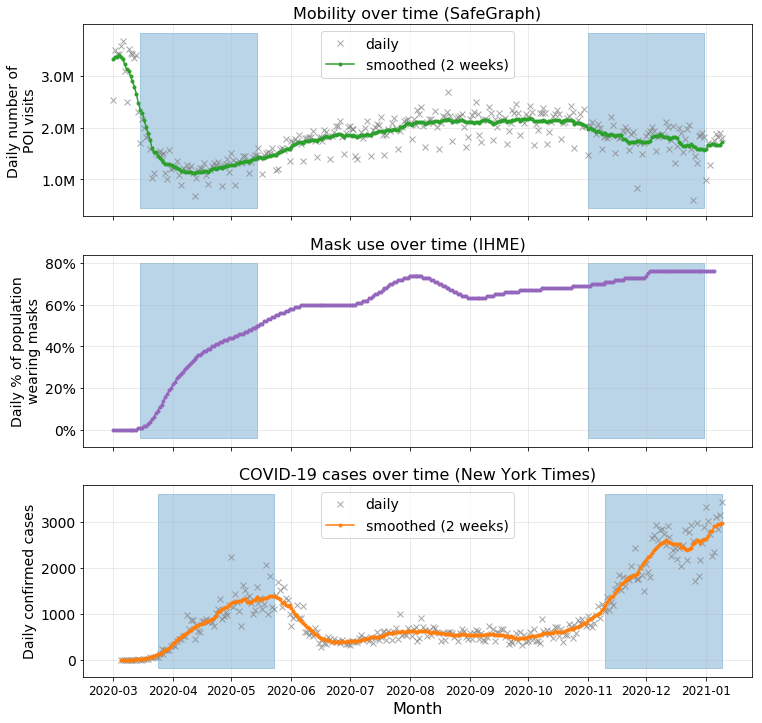

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

ax = axes[0]
ax.set_title('Mobility over time (SafeGraph)', fontsize=16)
ts = get_timeseries_for_corresponding_dates(daily_visits, visits_dates, all_dates)
ax.plot_date(all_dates, ts, marker='x', alpha=0.7, color='grey', label='daily')
ts = get_timeseries_for_corresponding_dates(smoothed_daily_visits, visits_dates, all_dates)
ax.plot_date(all_dates, ts, linestyle='-', marker='.', color='tab:green', label='smoothed (2 weeks)')
ymin, ymax = ax.get_ylim()
for start, end in time_periods:
    ax.fill_betweenx([ymin, ymax], [start, start], [end, end], color='tab:blue', alpha=0.3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax.tick_params(labelsize=14)
ax.grid(alpha=0.3)
ax.set_ylabel('Daily number of\nPOI visits', fontsize=14)
ax.legend(loc='upper center', fontsize=14)

ax = axes[1]
ax.set_title('Mask use over time (IHME)', fontsize=16)
ts = get_timeseries_for_corresponding_dates(daily_mask_use, mask_dates, all_dates)
ax.plot_date(all_dates, ts, linestyle='-', marker='.', color='tab:purple')
ymin, ymax = ax.get_ylim()
for start, end in time_periods:
    ax.fill_betweenx([ymin, ymax], [start, start], [end, end], color='tab:blue', alpha=0.3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_decimal_as_percent))
ax.tick_params(labelsize=14)
ax.grid(alpha=0.3)
ax.set_ylabel('Daily % of population\nwearing masks', fontsize=14)

ax = axes[2]
ax.set_title('COVID-19 cases over time (New York Times)', fontsize=16)
ts = get_timeseries_for_corresponding_dates(real_cases, real_dates, all_dates)
ax.plot_date(all_dates, ts, marker='x', alpha=0.7, color='grey', label='daily')
ts = get_timeseries_for_corresponding_dates(smoothed_cases, real_dates, all_dates)
ax.plot_date(all_dates, ts, linestyle='-', marker='.', color='tab:orange', label='smoothed (2 weeks)')
ymin, ymax = ax.get_ylim()
for start, end in time_periods:
    start_lagged = start + datetime.timedelta(days=DETECTION_LAG)
    end_lagged = end + datetime.timedelta(days=DETECTION_LAG)
    ax.fill_betweenx([ymin, ymax], [start_lagged, start_lagged], [end_lagged, end_lagged], color='tab:blue', alpha=0.3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=12)
ax.grid(alpha=0.3)
ax.set_ylabel('Daily confirmed cases', fontsize=14)
ax.legend(loc='upper center', fontsize=14)
ax.set_xlabel('Month', fontsize=16)

## POI-CBG network stats (Table 1)

In [8]:
msas = ['Washington_Arlington_Alexandria_DC_VA_MD_WV', 'Richmond_VA', 'Virginia_Beach_Norfolk_Newport_News_VA_NC']
min_datetime = datetime.datetime(2020, 11, 1, 0)
max_datetime = datetime.datetime(2020, 12, 31, 23)
msa2ipf = {}
for msa_name in msas:
    ipf_out, poi_ids, cbg_ids = helper.load_ipf_output_for_hours(msa_name, min_datetime, max_datetime, return_ids=True)
    msa2ipf[msa_name] = (ipf_out, poi_ids, cbg_ids)

Loading IPF output for 1464 hours
Finished loading IPF output in 181.33s [0.12s per hour]
Loading IPF output for 1464 hours
Finished loading IPF output in 45.79s [0.03s per hour]
Loading IPF output for 1464 hours
Finished loading IPF output in 68.65s [0.05s per hour]


In [9]:
rows = []
for msa_name in msa2ipf:
    ipf_out, poi_ids, cbg_ids = msa2ipf[msa_name]
    total = 0
    for m in ipf_out:
        nonzero = np.sum(m > 0)
        total += nonzero
    print('%s: num POIs = %d, num CBGs = %d, num edges = %d' % (msa_name, len(poi_ids), len(cbg_ids), total))
    rows.append({'msa':msa_name, 'pois':len(poi_ids), 'cbgs':len(cbg_ids), 'edges':total})
columns = list(rows[0].keys())
df = pd.DataFrame(rows, columns=columns)

Washington_Arlington_Alexandria_DC_VA_MD_WV: num POIs = 40467, num CBGs = 4904, num edges = 2095359467
Richmond_VA: num POIs = 9917, num CBGs = 1098, num edges = 516647719
Virginia_Beach_Norfolk_Newport_News_VA_NC: num POIs = 13360, num CBGs = 1607, num edges = 786389095


In [10]:
acs_d = helper.load_and_reconcile_multiple_acs_data()
cbgs_to_census_pops = dict(zip(acs_d['census_block_group'].values,
                               acs_d['total_cbg_population_2018_1YR'].values))  # use most recent population data
total_pop_sizes = []
for msa_name in df.msa.values:
    cbgs = msa2ipf[msa_name][2]
    pop_sizes = [cbgs_to_census_pops[c] for c in cbgs]
    total_pop_sizes.append(np.sum(pop_sizes))
df['pop_size'] = total_pop_sizes
df

220333 rows of 2018 1-year ACS data read
217739 rows of 2017 5-year ACS data read


,msa,pois,cbgs,edges,pop_size
0,Washington_Arlington_Alexandria_DC_VA_MD_WV,40467,4904,2095359467,9200384
1,Richmond_VA,9917,1098,516647719,2048200
2,Virginia_Beach_Norfolk_Newport_News_VA_NC,13360,1607,786389095,2854769


# 2. Model fit

In [19]:
def plot_model_fit_for_msa(best_models, msa_name, ax, min_datetime, max_datetime,
                           mode='cases', train_test_partition=None, additional_kwargs=None):
    msa_best_models = best_models[best_models.MSA_name == msa_name]
    nyt_outcomes, _, _, _, _ = get_variables_for_evaluating_msa_model(msa_name)  
    lag = DEATH_LAG if mode == 'deaths' else DETECTION_LAG
    other_plotting_kwargs =  {
            'plot_log':False, 
            'plot_legend':True,
            'plot_errorbars':True,
            'xticks':[min_datetime + datetime.timedelta(days=lag),
                      max_datetime + datetime.timedelta(days=lag)],                                                                             
            'x_range':[min_datetime + datetime.timedelta(days=lag),
                       max_datetime + datetime.timedelta(days=lag)],        
            'plot_daily_not_cumulative':True,
            'model_line_label': 'Model simulated',
            'true_line_label': 'Reported %s' % mode,
            'title_fontsize':30,
            'marker_size':5,
            'real_data_color':'tab:orange',
            'model_color':'tab:blue',
            'plot_mode':mode,
    }
    if additional_kwargs is not None:
        for k,v in additional_kwargs.items():
            other_plotting_kwargs[k] = v
    score_dict = plot_best_models_fit_for_msa(msa_best_models, msa_name, ax, key_to_sort_by=None, train_test_partition=train_test_partition, 
                                 plotting_kwargs=other_plotting_kwargs, use_given_df=True)
    ax.grid(alpha=0.1)
    ax.set_ylabel('Daily confirmed %s' % mode, fontsize=20)
    return score_dict

def compute_rmses(pred_dates, pred_data, real_dates, real_data, train_test_partition=None, normalized=False):
    assert pred_data.shape[1] == len(pred_dates)
    assert len(real_data) == len(real_dates)
    overlap_dates = sorted(set(pred_dates).intersection(set(real_dates)))
    y_true = []
    y_pred = []
    for dt in overlap_dates:
        if train_test_partition is None or dt >= train_test_partition:
            pred_index = pred_dates.index(dt)
            pred_vec = pred_data[:, pred_index]
            y_pred.append(pred_vec)
            real_index = real_dates.index(dt)
            observed = real_data[real_index]
            y_true.append(observed)
    y_pred = np.array(y_pred).T  # num seeds x dates 
    y_true = np.array(y_true)
    assert y_pred.shape[1] == len(y_true)
    
    mean_rmse_over_seeds = RMSE(y_true, y_pred)
    rmse_of_mean = RMSE(y_true, np.mean(y_pred, axis=0))
    if normalized:  # normalize by mean of y_true so that we can compare across time periods / MSAs 
        mean_rmse_over_seeds = mean_rmse_over_seeds / np.mean(y_true)
        rmse_of_mean = rmse_of_mean / np.mean(y_true)
    return mean_rmse_over_seeds, rmse_of_mean

## Washington DC, first wave (Table 2, Figure 4, Table A2)

## Columbia

In [24]:
msa_name = 'Columbia_SC'
# msa_name = 'Greenville_Anderson_SC'
# msa_name = 'Charleston_North_Charleston_SC'

key_to_sort_by = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'
min_datetime = datetime.datetime(2020, 12, 20)
max_datetime = datetime.datetime(2021, 1, 30)

Loading models with timestrings between 2021_11_28_13_16203770 and 2021_11_28_13_22203770
6476 files in directory /media/gpu/Seagate/extra_safegraph_aggregate_models/data_and_model_configs
Found 28 fitted models for Columbia_SC
Time to load and score all models: 1.113s -> 0.040s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.000
Columbia_SC: 1 within loss tol -> keeping 1
                                                                                              home_beta  poi_psi
11  [0.01479, 0.014651343749999999, 0.0145126875, 0.014374031249999999, 0.014235375, 0.0140967187499...     9.18
0.00924375 0.01479
Plotting predictions from 1 models
Applying time-varying CDR to visualization


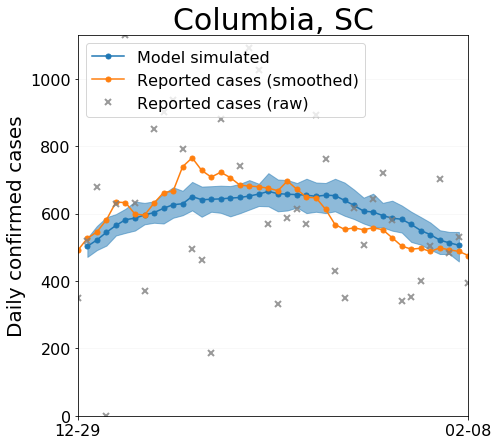

,timestring,data_kwargs,model_kwargs,results,experiment_to_run,final infected fraction,loss_dict_eval_start_time_cases,loss_dict_eval_end_time_cases,loss_dict_cumulative_predicted_cases,loss_dict_cumulative_true_cases,loss_dict_cumulative_cases_RMSE,loss_dict_cumulative_cases_MSE,loss_dict_daily_cases_RMSE,loss_dict_daily_cases_MSE,loss_dict_daily_cases_RMSE_time_varying_cdr,loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr,loss_dict_daily_cases_MRE_thres-1_sum,loss_dict_daily_cases_MRE_thres-10_sum,loss_dict_daily_cases_MRE_thres-20_sum,loss_dict_daily_cases_MRE_thres-50_sum,loss_dict_daily_cases_MRE_thres-100_sum,loss_dict_daily_cases_poisson_NLL_thres-1_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-1_sum,loss_dict_daily_cases_poisson_NLL_thres-10_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-10_sum,...,agg_county_loss_dict_max_daily_deaths_RMSE,agg_county_loss_dict_unweighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_weighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_max_daily_deaths_per_capita_RMSE,home_beta,poi_psi,p_sick_at_t0,inter_cbg_gamma,just_compute_r0,min_datetime,max_datetime,model_init_kwargs,simulation_kwargs,poi_attributes_to_clip,include_cbg_prop_out,include_inter_cbg_travel,include_mask_use,counties_to_track,poi_cbg_visits_list,poi_ids,cbg_ids,MSA_name,start_beta,end_beta,beta_ratio
11,2021_11_28_13_18_45_911113_normal_grid_search,"{'MSA_name': 'Columbia_SC', 'nrows': None}","{'min_datetime': 2020-12-20 00:00:00, 'max_datetime': 2021-01-29 23:00:00, 'exogenous_model_kwar...",None,normal_grid_search,"[0.14097528719646915, 0.1399041716303943, 0.1407160362951262, 0.13952894006266106, 0.13946491453...",2020-12-29,2021-02-07,"[[43066.799999999996, 43523.4, 44017.2, 44530.2, 45050.4, 45600.0, 46143.6, 46690.799999999996, ...","[48961, 49481, 50161, 50161, 50790, 51919, 52550, 52920, 53772, 54672, 55610, 56401, 56895, 5735...",7697.12012,5.933761e+07,244.676434,59889.5964,238.041421,58.344058,0.267717,0.267717,0.267717,0.267717,0.267717,1716.27099,56020.633224,1716.27099,56020.633224,...,3.816518,0.000023,0.000012,0.000043,"[0.01479, 0.014651343749999999, 0.0145126875, 0.014374031249999999, 0.014235375, 0.0140967187499...",9.18,None,None,False,2020-12-20,2021-01-29 23:00:00,{'num_seeds': 30},"{'use_aggregate_mobility': False, 'use_home_proportion_beta': False, 'use_inter_cbg_leak_factor'...","{'clip_areas': True, 'clip_dwell_times': True, 'clip_visits': True}",False,False,True,"[45039, 45063, 45017, 45079, 45081, 45055]","[ (3, 893)\t0.2289944516825042\n (3, 878)\t0.47933067639604404\n (3, 872)\t0.2162319608843065...","[sg:003140f5b1dc4f599315dc9f5b1fd623, sg:084a87f9d18a4ab6bd97647f6da414b0, sg:0ce97481f4df412fb5...","[130510107001, 130730301023, 130730303042, 130730303061, 130730303082, 130730304022, 13073030503...",Columbia_SC,0.01479,0.009244,0.625


In [25]:
# full model

import matplotlib.pyplot as plt



max_timestring = '2021_11_28_02_44_203770'  # group 2
min_timestring = '2021_11_27_23_34_000000'

max_timestring = '2021_11_27_23_35_000000' # group 1
min_timestring = '2021_11_27_19_45_000000'

max_timestring = '2021_11_28_13_00_203770'  # group 3   # 931 , 
min_timestring = '2021_11_28_09_10_203770'    # 931 2021_11_28_12_33_55_506980_normal_grid_search_normal_grid_search

# max_timestring = '2021_11_28_13_15_203770'  # group 4  bad, not use 
# min_timestring = '2021_11_28_13_05_203770'    

# max_timestring = '2021_11_28_13_44_203770'  # group 5  GOOD:  # 2021_11_28_13_18_45_911113_normal_grid_search_normal_grid_search
# min_timestring = '2021_11_28_13_23_203770' 

max_timestring = '2021_11_28_13_22203770'  # group 4.5 GOOD:  # 2021_11_28_13_18_45_911113_normal_grid_search_normal_grid_search
min_timestring = '2021_11_28_13_16203770' 

# max_timestring = '2022_01_02_17_22203770'  # Greenville_Anderson_SC, Best: 2022_01_02_14_46_37_084470_normal_grid_search_normal_grid_search	
# min_timestring = '2022_01_02_13_55203770' 

# max_timestring = '2022_01_03_00_22203770'  # Charleston_North_Charleston_SC, Best: 2022_01_02_23_03_13_321102_normal_grid_search_normal_grid_search	
# min_timestring = '2022_01_02_20_55203770' 

# max_timestring = '2022_01_03_30_22203770'  # Charleston_North_Charleston_SC, Best: * 1.1, not good.	
# min_timestring = '2022_01_03_00_22203770' 

# max_timestring = '2022_01_03_08_30203770'  # Charleston_North_Charleston_SC, Best: * 1.02,  good.	
# min_timestring = '2022_01_03_08_22203770' 



expected_num_jobs = 1050
gridsearch_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                   min_timestring=min_timestring,
                                                   max_timestring=max_timestring, 
                                                   required_properties={'experiment_to_run':'normal_grid_search'})
# assert len(gridsearch_df) == expected_num_jobs, len(gridsearch_df)
gridsearch_df['MSA_name'] = gridsearch_df['data_kwargs'].map(lambda x:x['MSA_name'])
gridsearch_df['start_beta'] = gridsearch_df['home_beta'].apply(lambda x:x[0])
gridsearch_df['end_beta'] = gridsearch_df['home_beta'].apply(lambda x:x[-1])
gridsearch_df['beta_ratio'] = gridsearch_df.end_beta.values / gridsearch_df.start_beta.values

best_models_df = get_best_models_for_all_msas(gridsearch_df, key_to_sort_by, loss_tolerance=1.0, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)

print(best_models_df[['home_beta', 'poi_psi']])
print(best_models_df['home_beta'].iloc[0].min(), best_models_df['home_beta'].iloc[0].max())


fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
plt.show()
best_models_df

Plotting predictions from 1 models
Applying time-varying CDR to visualization


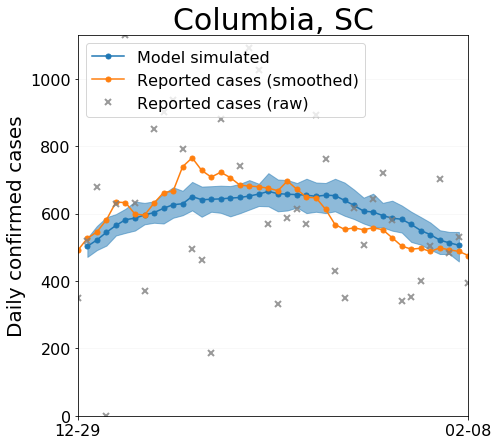

,timestring,data_kwargs,model_kwargs,results,experiment_to_run,final infected fraction,loss_dict_eval_start_time_cases,loss_dict_eval_end_time_cases,loss_dict_cumulative_predicted_cases,loss_dict_cumulative_true_cases,loss_dict_cumulative_cases_RMSE,loss_dict_cumulative_cases_MSE,loss_dict_daily_cases_RMSE,loss_dict_daily_cases_MSE,loss_dict_daily_cases_RMSE_time_varying_cdr,loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr,loss_dict_daily_cases_MRE_thres-1_sum,loss_dict_daily_cases_MRE_thres-10_sum,loss_dict_daily_cases_MRE_thres-20_sum,loss_dict_daily_cases_MRE_thres-50_sum,loss_dict_daily_cases_MRE_thres-100_sum,loss_dict_daily_cases_poisson_NLL_thres-1_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-1_sum,loss_dict_daily_cases_poisson_NLL_thres-10_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-10_sum,...,agg_county_loss_dict_max_daily_deaths_RMSE,agg_county_loss_dict_unweighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_weighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_max_daily_deaths_per_capita_RMSE,home_beta,poi_psi,p_sick_at_t0,inter_cbg_gamma,just_compute_r0,min_datetime,max_datetime,model_init_kwargs,simulation_kwargs,poi_attributes_to_clip,include_cbg_prop_out,include_inter_cbg_travel,include_mask_use,counties_to_track,poi_cbg_visits_list,poi_ids,cbg_ids,MSA_name,start_beta,end_beta,beta_ratio
11,2021_11_28_13_18_45_911113_normal_grid_search,"{'MSA_name': 'Columbia_SC', 'nrows': None}","{'min_datetime': 2020-12-20 00:00:00, 'max_datetime': 2021-01-29 23:00:00, 'exogenous_model_kwar...",None,normal_grid_search,"[0.14097528719646915, 0.1399041716303943, 0.1407160362951262, 0.13952894006266106, 0.13946491453...",2020-12-29,2021-02-07,"[[43066.799999999996, 43523.4, 44017.2, 44530.2, 45050.4, 45600.0, 46143.6, 46690.799999999996, ...","[48961, 49481, 50161, 50161, 50790, 51919, 52550, 52920, 53772, 54672, 55610, 56401, 56895, 5735...",7697.12012,5.933761e+07,244.676434,59889.5964,238.041421,58.344058,0.267717,0.267717,0.267717,0.267717,0.267717,1716.27099,56020.633224,1716.27099,56020.633224,...,3.816518,0.000023,0.000012,0.000043,"[0.01479, 0.014651343749999999, 0.0145126875, 0.014374031249999999, 0.014235375, 0.0140967187499...",9.18,None,None,False,2020-12-20,2021-01-29 23:00:00,{'num_seeds': 30},"{'use_aggregate_mobility': False, 'use_home_proportion_beta': False, 'use_inter_cbg_leak_factor'...","{'clip_areas': True, 'clip_dwell_times': True, 'clip_visits': True}",False,False,True,"[45039, 45063, 45017, 45079, 45081, 45055]","[ (3, 893)\t0.2289944516825042\n (3, 878)\t0.47933067639604404\n (3, 872)\t0.2162319608843065...","[sg:003140f5b1dc4f599315dc9f5b1fd623, sg:084a87f9d18a4ab6bd97647f6da414b0, sg:0ce97481f4df412fb5...","[130510107001, 130730301023, 130730303042, 130730303061, 130730303082, 130730304022, 13073030503...",Columbia_SC,0.01479,0.009244,0.625


In [27]:
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)

plt.title("Columbia, SC", fontdict={'fontsize':30})
plt.show()
best_models_df

## Charleston

Loading models with timestrings between 2022_01_03_08_22203770 and 2022_01_03_08_30203770
6476 files in directory /media/gpu/Seagate/extra_safegraph_aggregate_models/data_and_model_configs
Found 1 fitted models for Charleston_North_Charleston_SC
Time to load and score all models: 0.533s -> 0.533s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.000
Charleston_North_Charleston_SC: 1 within loss tol -> keeping 1
                                                                                             home_beta    poi_psi
0  [0.01496, 0.014773, 0.014586, 0.014399, 0.014211999999999999, 0.014025000000000001, 0.013838, 0....  18.942857
0.00748 0.01496
Plotting predictions from 1 models
Applying time-varying CDR to visualization


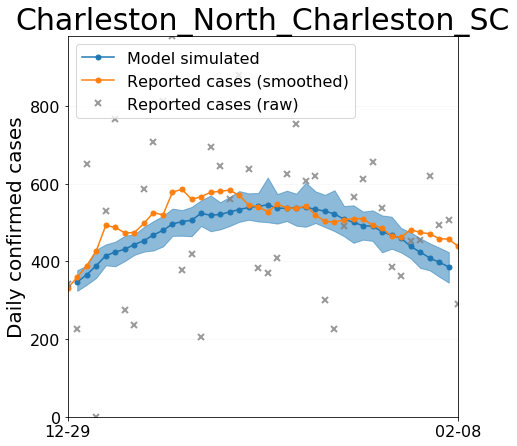

,timestring,data_kwargs,model_kwargs,results,experiment_to_run,final infected fraction,loss_dict_eval_start_time_cases,loss_dict_eval_end_time_cases,loss_dict_cumulative_predicted_cases,loss_dict_cumulative_true_cases,loss_dict_cumulative_cases_RMSE,loss_dict_cumulative_cases_MSE,loss_dict_daily_cases_RMSE,loss_dict_daily_cases_MSE,loss_dict_daily_cases_RMSE_time_varying_cdr,loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr,loss_dict_daily_cases_MRE_thres-1_sum,loss_dict_daily_cases_MRE_thres-10_sum,loss_dict_daily_cases_MRE_thres-20_sum,loss_dict_daily_cases_MRE_thres-50_sum,loss_dict_daily_cases_MRE_thres-100_sum,loss_dict_daily_cases_poisson_NLL_thres-1_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-1_sum,loss_dict_daily_cases_poisson_NLL_thres-10_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-10_sum,...,agg_county_loss_dict_max_daily_deaths_RMSE,agg_county_loss_dict_unweighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_weighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_max_daily_deaths_per_capita_RMSE,home_beta,poi_psi,p_sick_at_t0,inter_cbg_gamma,just_compute_r0,min_datetime,max_datetime,model_init_kwargs,simulation_kwargs,poi_attributes_to_clip,include_cbg_prop_out,include_inter_cbg_travel,include_mask_use,counties_to_track,poi_cbg_visits_list,poi_ids,cbg_ids,MSA_name,start_beta,end_beta,beta_ratio
0,2022_01_03_08_25_normal_grid_search,"{'MSA_name': 'Charleston_North_Charleston_SC', 'nrows': None}","{'min_datetime': 2020-12-20 00:00:00, 'max_datetime': 2021-01-29 23:00:00, 'exogenous_model_kwar...",None,normal_grid_search,"[0.13292937099671914, 0.13179861311997507, 0.13301170773531704, 0.13262307832913509, 0.133465657...",2020-12-29,2021-02-07,"[[37091.4, 37407.6, 37774.2, 38129.4, 38529.0, 38914.799999999996, 39350.4, 39786.6, 40203.6, 40...","[40831, 41058, 41709, 41709, 42238, 43005, 43279, 43516, 44103, 44811, 45625, 46605, 46983, 4740...",5410.904567,2.934974e+07,209.273918,43815.8078,200.024065,46.986551,0.284047,0.284047,0.284047,0.284047,0.284047,1608.063108,53535.81834,1608.063108,53535.81834,...,3.00561,0.000008,0.000008,0.000008,"[0.01496, 0.014773, 0.014586, 0.014399, 0.014211999999999999, 0.014025000000000001, 0.013838, 0....",18.942857,None,None,False,2020-12-20,2021-01-29 23:00:00,{'num_seeds': 30},"{'use_aggregate_mobility': False, 'use_home_proportion_beta': False, 'use_inter_cbg_leak_factor'...","{'clip_areas': True, 'clip_dwell_times': True, 'clip_visits': True}",False,False,True,"[45019, 45015, 45035]","[ (13, 720)\t0.27553844493055735\n (13, 601)\t0.39470269078646036\n (13, 476)\t0.000679470508...","[sg:0719f423492c4f229548ab9bb46aedb7, sg:09f3799061e744e586b1c9e32b0207cb, sg:1bbe25edd2714a97bf...","[130299203062, 130510107001, 130510108021, 130730303042, 130730303082, 131030303011, 37025041301...",Charleston_North_Charleston_SC,0.01496,0.00748,0.5


In [34]:
# full model
msa_name = 'Charleston_North_Charleston_SC'
key_to_sort_by = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'
min_datetime = datetime.datetime(2020, 12, 20)
max_datetime = datetime.datetime(2021, 1, 30)


import matplotlib.pyplot as plt



max_timestring = '2021_11_28_02_44_203770'  # group 2
min_timestring = '2021_11_27_23_34_000000'

max_timestring = '2021_11_27_23_35_000000' # group 1
min_timestring = '2021_11_27_19_45_000000'

max_timestring = '2021_11_28_13_00_203770'  # group 3   # 931 , 
min_timestring = '2021_11_28_09_10_203770'    # 931 2021_11_28_12_33_55_506980_normal_grid_search_normal_grid_search

# max_timestring = '2021_11_28_13_15_203770'  # group 4  bad, not use 
# min_timestring = '2021_11_28_13_05_203770'    

# max_timestring = '2021_11_28_13_44_203770'  # group 5  GOOD:  # 2021_11_28_13_18_45_911113_normal_grid_search_normal_grid_search
# min_timestring = '2021_11_28_13_23_203770' 

# max_timestring = '2021_11_28_13_22203770'  # group 4.5 OOD:  # 2021_11_28_13_18_45_911113_normal_grid_search_normal_grid_search
# min_timestring = '2021_11_28_13_16203770' 

max_timestring = '2022_01_02_17_22203770'  # Greenville_Anderson_SC, Best: 2022_01_02_14_46_37_084470_normal_grid_search_normal_grid_search	
min_timestring = '2022_01_02_13_55203770' 

max_timestring = '2022_01_03_00_22203770'  # Charleston_North_Charleston_SC, Best: 2022_01_02_23_03_13_321102_normal_grid_search_normal_grid_search	
min_timestring = '2022_01_02_20_55203770' 

# max_timestring = '2022_01_03_30_22203770'  # Charleston_North_Charleston_SC, Best: * 1.1, not good.	
# min_timestring = '2022_01_03_00_22203770' 

max_timestring = '2022_01_03_08_30203770'  # Charleston_North_Charleston_SC, Best: * 1.02,  good.	
min_timestring = '2022_01_03_08_22203770' 



expected_num_jobs = 1050
gridsearch_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                   min_timestring=min_timestring,
                                                   max_timestring=max_timestring, 
                                                   required_properties={'experiment_to_run':'normal_grid_search'})
# assert len(gridsearch_df) == expected_num_jobs, len(gridsearch_df)
gridsearch_df['MSA_name'] = gridsearch_df['data_kwargs'].map(lambda x:x['MSA_name'])
gridsearch_df['start_beta'] = gridsearch_df['home_beta'].apply(lambda x:x[0])
gridsearch_df['end_beta'] = gridsearch_df['home_beta'].apply(lambda x:x[-1])
gridsearch_df['beta_ratio'] = gridsearch_df.end_beta.values / gridsearch_df.start_beta.values

best_models_df = get_best_models_for_all_msas(gridsearch_df, key_to_sort_by, loss_tolerance=1.0, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)

print(best_models_df[['home_beta', 'poi_psi']])
print(best_models_df['home_beta'].iloc[0].min(), best_models_df['home_beta'].iloc[0].max())


fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)

plt.show()
best_models_df

Plotting predictions from 1 models
Applying time-varying CDR to visualization


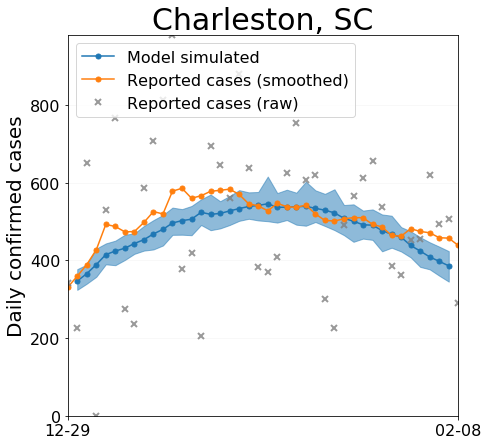

,timestring,data_kwargs,model_kwargs,results,experiment_to_run,final infected fraction,loss_dict_eval_start_time_cases,loss_dict_eval_end_time_cases,loss_dict_cumulative_predicted_cases,loss_dict_cumulative_true_cases,loss_dict_cumulative_cases_RMSE,loss_dict_cumulative_cases_MSE,loss_dict_daily_cases_RMSE,loss_dict_daily_cases_MSE,loss_dict_daily_cases_RMSE_time_varying_cdr,loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr,loss_dict_daily_cases_MRE_thres-1_sum,loss_dict_daily_cases_MRE_thres-10_sum,loss_dict_daily_cases_MRE_thres-20_sum,loss_dict_daily_cases_MRE_thres-50_sum,loss_dict_daily_cases_MRE_thres-100_sum,loss_dict_daily_cases_poisson_NLL_thres-1_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-1_sum,loss_dict_daily_cases_poisson_NLL_thres-10_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-10_sum,...,agg_county_loss_dict_max_daily_deaths_RMSE,agg_county_loss_dict_unweighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_weighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_max_daily_deaths_per_capita_RMSE,home_beta,poi_psi,p_sick_at_t0,inter_cbg_gamma,just_compute_r0,min_datetime,max_datetime,model_init_kwargs,simulation_kwargs,poi_attributes_to_clip,include_cbg_prop_out,include_inter_cbg_travel,include_mask_use,counties_to_track,poi_cbg_visits_list,poi_ids,cbg_ids,MSA_name,start_beta,end_beta,beta_ratio
0,2022_01_03_08_25_normal_grid_search,"{'MSA_name': 'Charleston_North_Charleston_SC', 'nrows': None}","{'min_datetime': 2020-12-20 00:00:00, 'max_datetime': 2021-01-29 23:00:00, 'exogenous_model_kwar...",None,normal_grid_search,"[0.13292937099671914, 0.13179861311997507, 0.13301170773531704, 0.13262307832913509, 0.133465657...",2020-12-29,2021-02-07,"[[37091.4, 37407.6, 37774.2, 38129.4, 38529.0, 38914.799999999996, 39350.4, 39786.6, 40203.6, 40...","[40831, 41058, 41709, 41709, 42238, 43005, 43279, 43516, 44103, 44811, 45625, 46605, 46983, 4740...",5410.904567,2.934974e+07,209.273918,43815.8078,200.024065,46.986551,0.284047,0.284047,0.284047,0.284047,0.284047,1608.063108,53535.81834,1608.063108,53535.81834,...,3.00561,0.000008,0.000008,0.000008,"[0.01496, 0.014773, 0.014586, 0.014399, 0.014211999999999999, 0.014025000000000001, 0.013838, 0....",18.942857,None,None,False,2020-12-20,2021-01-29 23:00:00,{'num_seeds': 30},"{'use_aggregate_mobility': False, 'use_home_proportion_beta': False, 'use_inter_cbg_leak_factor'...","{'clip_areas': True, 'clip_dwell_times': True, 'clip_visits': True}",False,False,True,"[45019, 45015, 45035]","[ (13, 720)\t0.27553844493055735\n (13, 601)\t0.39470269078646036\n (13, 476)\t0.000679470508...","[sg:0719f423492c4f229548ab9bb46aedb7, sg:09f3799061e744e586b1c9e32b0207cb, sg:1bbe25edd2714a97bf...","[130299203062, 130510107001, 130510108021, 130730303042, 130730303082, 131030303011, 37025041301...",Charleston_North_Charleston_SC,0.01496,0.00748,0.5


In [36]:
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)

plt.title("Charleston, SC", fontdict={'fontsize':30})
plt.show()
best_models_df

## Greenville

Loading models with timestrings between 2022_01_02_13_55203770 and 2022_01_02_17_22203770
6476 files in directory /media/gpu/Seagate/extra_safegraph_aggregate_models/data_and_model_configs
Found 1058 fitted models for Greenville_Anderson_SC
Time to load and score all models: 2.129s -> 0.002s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.000
Greenville_Anderson_SC: 1 within loss tol -> keeping 1
                                                                                               home_beta  poi_psi
256  [0.01496, 0.014773, 0.014586, 0.014399, 0.014211999999999999, 0.014025000000000001, 0.013838, 0....      5.1
0.00748 0.01496
Plotting predictions from 1 models
Applying time-varying CDR to visualization


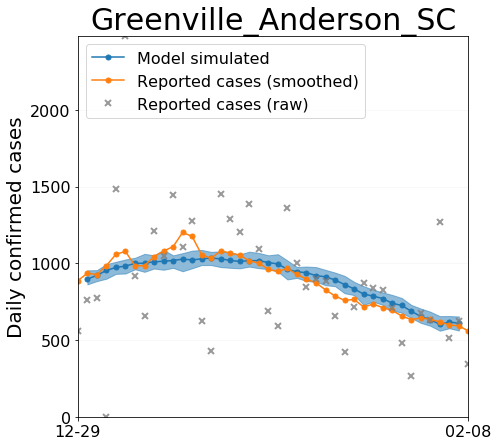

,timestring,data_kwargs,model_kwargs,results,experiment_to_run,final infected fraction,loss_dict_eval_start_time_cases,loss_dict_eval_end_time_cases,loss_dict_cumulative_predicted_cases,loss_dict_cumulative_true_cases,loss_dict_cumulative_cases_RMSE,loss_dict_cumulative_cases_MSE,loss_dict_daily_cases_RMSE,loss_dict_daily_cases_MSE,loss_dict_daily_cases_RMSE_time_varying_cdr,loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr,loss_dict_daily_cases_MRE_thres-1_sum,loss_dict_daily_cases_MRE_thres-10_sum,loss_dict_daily_cases_MRE_thres-20_sum,loss_dict_daily_cases_MRE_thres-50_sum,loss_dict_daily_cases_MRE_thres-100_sum,loss_dict_daily_cases_poisson_NLL_thres-1_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-1_sum,loss_dict_daily_cases_poisson_NLL_thres-10_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-10_sum,...,agg_county_loss_dict_max_daily_deaths_RMSE,agg_county_loss_dict_unweighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_weighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_max_daily_deaths_per_capita_RMSE,home_beta,poi_psi,p_sick_at_t0,inter_cbg_gamma,just_compute_r0,min_datetime,max_datetime,model_init_kwargs,simulation_kwargs,poi_attributes_to_clip,include_cbg_prop_out,include_inter_cbg_travel,include_mask_use,counties_to_track,poi_cbg_visits_list,poi_ids,cbg_ids,MSA_name,start_beta,end_beta,beta_ratio
256,2022_01_02_14_46_37_084470_normal_grid_search,"{'MSA_name': 'Greenville_Anderson_SC', 'nrows': None}","{'min_datetime': 2020-12-20 00:00:00, 'max_datetime': 2021-01-29 23:00:00, 'exogenous_model_kwar...",None,normal_grid_search,"[0.15287738119616295, 0.15388530898704586, 0.15446027993266298, 0.15352468891199647, 0.153745422...",2020-12-29,2021-02-07,"[[53666.4, 54492.6, 55346.4, 56270.4, 57186.0, 58092.0, 58992.6, 59895.0, 60812.399999999994, 61...","[61660, 62421, 63193, 63193, 64678, 67157, 68077, 68732, 69945, 70993, 72438, 73543, 74818, 7544...",9995.079087,9.998130e+07,403.982556,163221.5367,395.832557,68.689063,0.212114,0.212114,0.212114,0.212114,0.212114,2797.306179,88732.227431,2797.306179,88732.227431,...,6.907881,0.000023,0.000018,0.000037,"[0.01496, 0.014773, 0.014586, 0.014399, 0.014211999999999999, 0.014025000000000001, 0.013838, 0....",5.1,None,None,False,2020-12-20,2021-01-29 23:00:00,{'num_seeds': 30},"{'use_aggregate_mobility': False, 'use_home_proportion_beta': False, 'use_inter_cbg_leak_factor'...","{'clip_areas': True, 'clip_dwell_times': True, 'clip_visits': True}",False,False,True,"[45045, 45059, 45077, 45007]","[ (1, 926)\t0.06209145446126893\n (1, 913)\t0.023949315000219972\n (1, 905)\t0.24201453362046...","[sg:003ac77ae87346e59162e5b657edf9fe, sg:21da056d879c472a8d223de5fdd40e0f, sg:2ae7c73886b5424d85...","[130119704001, 130730303082, 131050001002, 131050001003, 131050002001, 131050002002, 13105000200...",Greenville_Anderson_SC,0.01496,0.00748,0.5


In [30]:
# full model
msa_name = 'Greenville_Anderson_SC'
key_to_sort_by = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'
min_datetime = datetime.datetime(2020, 12, 20)
max_datetime = datetime.datetime(2021, 1, 30)


import matplotlib.pyplot as plt



max_timestring = '2021_11_28_02_44_203770'  # group 2
min_timestring = '2021_11_27_23_34_000000'

max_timestring = '2021_11_27_23_35_000000' # group 1
min_timestring = '2021_11_27_19_45_000000'

max_timestring = '2021_11_28_13_00_203770'  # group 3   # 931 , 
min_timestring = '2021_11_28_09_10_203770'    # 931 2021_11_28_12_33_55_506980_normal_grid_search_normal_grid_search

# max_timestring = '2021_11_28_13_15_203770'  # group 4  bad, not use 
# min_timestring = '2021_11_28_13_05_203770'    

# max_timestring = '2021_11_28_13_44_203770'  # group 5  GOOD:  # 2021_11_28_13_18_45_911113_normal_grid_search_normal_grid_search
# min_timestring = '2021_11_28_13_23_203770' 

# max_timestring = '2021_11_28_13_22203770'  # group 4.5 OOD:  # 2021_11_28_13_18_45_911113_normal_grid_search_normal_grid_search
# min_timestring = '2021_11_28_13_16203770' 

max_timestring = '2022_01_02_17_22203770'  # Greenville_Anderson_SC, Best: 2022_01_02_14_46_37_084470_normal_grid_search_normal_grid_search	
min_timestring = '2022_01_02_13_55203770' 

# max_timestring = '2022_01_03_00_22203770'  # Charleston_North_Charleston_SC, Best: 2022_01_02_23_03_13_321102_normal_grid_search_normal_grid_search	
# min_timestring = '2022_01_02_20_55203770' 

# max_timestring = '2022_01_03_30_22203770'  # Charleston_North_Charleston_SC, Best: * 1.1, not good.	
# min_timestring = '2022_01_03_00_22203770' 

# max_timestring = '2022_01_03_08_30203770'  # Charleston_North_Charleston_SC, Best: * 1.02,  good.	
# min_timestring = '2022_01_03_08_22203770' 



expected_num_jobs = 1050
gridsearch_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                   min_timestring=min_timestring,
                                                   max_timestring=max_timestring, 
                                                   required_properties={'experiment_to_run':'normal_grid_search'})
# assert len(gridsearch_df) == expected_num_jobs, len(gridsearch_df)
gridsearch_df['MSA_name'] = gridsearch_df['data_kwargs'].map(lambda x:x['MSA_name'])
gridsearch_df['start_beta'] = gridsearch_df['home_beta'].apply(lambda x:x[0])
gridsearch_df['end_beta'] = gridsearch_df['home_beta'].apply(lambda x:x[-1])
gridsearch_df['beta_ratio'] = gridsearch_df.end_beta.values / gridsearch_df.start_beta.values

best_models_df = get_best_models_for_all_msas(gridsearch_df, key_to_sort_by, loss_tolerance=1.0, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)

print(best_models_df[['home_beta', 'poi_psi']])
print(best_models_df['home_beta'].iloc[0].min(), best_models_df['home_beta'].iloc[0].max())


fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)

plt.show()
best_models_df

Plotting predictions from 1 models
Applying time-varying CDR to visualization


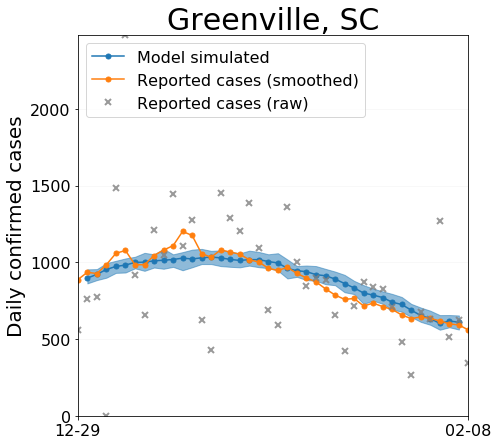

,timestring,data_kwargs,model_kwargs,results,experiment_to_run,final infected fraction,loss_dict_eval_start_time_cases,loss_dict_eval_end_time_cases,loss_dict_cumulative_predicted_cases,loss_dict_cumulative_true_cases,loss_dict_cumulative_cases_RMSE,loss_dict_cumulative_cases_MSE,loss_dict_daily_cases_RMSE,loss_dict_daily_cases_MSE,loss_dict_daily_cases_RMSE_time_varying_cdr,loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr,loss_dict_daily_cases_MRE_thres-1_sum,loss_dict_daily_cases_MRE_thres-10_sum,loss_dict_daily_cases_MRE_thres-20_sum,loss_dict_daily_cases_MRE_thres-50_sum,loss_dict_daily_cases_MRE_thres-100_sum,loss_dict_daily_cases_poisson_NLL_thres-1_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-1_sum,loss_dict_daily_cases_poisson_NLL_thres-10_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-10_sum,...,agg_county_loss_dict_max_daily_deaths_RMSE,agg_county_loss_dict_unweighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_weighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_max_daily_deaths_per_capita_RMSE,home_beta,poi_psi,p_sick_at_t0,inter_cbg_gamma,just_compute_r0,min_datetime,max_datetime,model_init_kwargs,simulation_kwargs,poi_attributes_to_clip,include_cbg_prop_out,include_inter_cbg_travel,include_mask_use,counties_to_track,poi_cbg_visits_list,poi_ids,cbg_ids,MSA_name,start_beta,end_beta,beta_ratio
256,2022_01_02_14_46_37_084470_normal_grid_search,"{'MSA_name': 'Greenville_Anderson_SC', 'nrows': None}","{'min_datetime': 2020-12-20 00:00:00, 'max_datetime': 2021-01-29 23:00:00, 'exogenous_model_kwar...",None,normal_grid_search,"[0.15287738119616295, 0.15388530898704586, 0.15446027993266298, 0.15352468891199647, 0.153745422...",2020-12-29,2021-02-07,"[[53666.4, 54492.6, 55346.4, 56270.4, 57186.0, 58092.0, 58992.6, 59895.0, 60812.399999999994, 61...","[61660, 62421, 63193, 63193, 64678, 67157, 68077, 68732, 69945, 70993, 72438, 73543, 74818, 7544...",9995.079087,9.998130e+07,403.982556,163221.5367,395.832557,68.689063,0.212114,0.212114,0.212114,0.212114,0.212114,2797.306179,88732.227431,2797.306179,88732.227431,...,6.907881,0.000023,0.000018,0.000037,"[0.01496, 0.014773, 0.014586, 0.014399, 0.014211999999999999, 0.014025000000000001, 0.013838, 0....",5.1,None,None,False,2020-12-20,2021-01-29 23:00:00,{'num_seeds': 30},"{'use_aggregate_mobility': False, 'use_home_proportion_beta': False, 'use_inter_cbg_leak_factor'...","{'clip_areas': True, 'clip_dwell_times': True, 'clip_visits': True}",False,False,True,"[45045, 45059, 45077, 45007]","[ (1, 926)\t0.06209145446126893\n (1, 913)\t0.023949315000219972\n (1, 905)\t0.24201453362046...","[sg:003ac77ae87346e59162e5b657edf9fe, sg:21da056d879c472a8d223de5fdd40e0f, sg:2ae7c73886b5424d85...","[130119704001, 130730303082, 131050001002, 131050001003, 131050002001, 131050002002, 13105000200...",Greenville_Anderson_SC,0.01496,0.00748,0.5


In [21]:
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)

plt.title("Greenville, SC", fontdict={'fontsize':30})
plt.show()
best_models_df

     start_beta  end_beta    poi_psi
717    0.014667  0.007333  18.571429
0.007333333333333333 0.014666666666666666
Plotting predictions from 1 models
Applying time-varying CDR to visualization


/media/gpu/easystore/covid-mobility-tool/model_experiments.py:2811: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(real_dates, real_data, marker='x', c='grey', alpha=0.8,


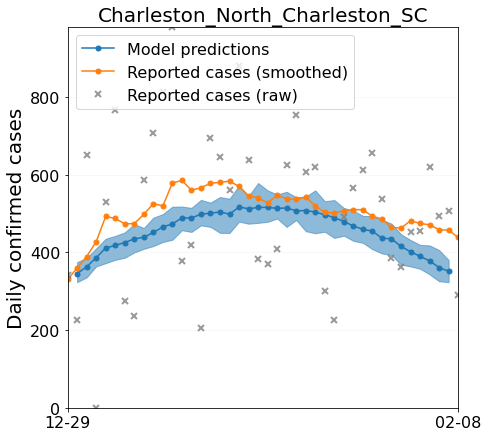

,timestring,data_kwargs,model_kwargs,results,experiment_to_run,final infected fraction,loss_dict_eval_start_time_cases,loss_dict_eval_end_time_cases,loss_dict_cumulative_predicted_cases,loss_dict_cumulative_true_cases,loss_dict_cumulative_cases_RMSE,loss_dict_cumulative_cases_MSE,loss_dict_daily_cases_RMSE,loss_dict_daily_cases_MSE,loss_dict_daily_cases_RMSE_time_varying_cdr,loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr,loss_dict_daily_cases_MRE_thres-1_sum,loss_dict_daily_cases_MRE_thres-10_sum,loss_dict_daily_cases_MRE_thres-20_sum,loss_dict_daily_cases_MRE_thres-50_sum,loss_dict_daily_cases_MRE_thres-100_sum,loss_dict_daily_cases_poisson_NLL_thres-1_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-1_sum,loss_dict_daily_cases_poisson_NLL_thres-10_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-10_sum,...,agg_county_loss_dict_max_daily_deaths_RMSE,agg_county_loss_dict_unweighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_weighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_max_daily_deaths_per_capita_RMSE,home_beta,poi_psi,p_sick_at_t0,inter_cbg_gamma,just_compute_r0,min_datetime,max_datetime,model_init_kwargs,simulation_kwargs,poi_attributes_to_clip,include_cbg_prop_out,include_inter_cbg_travel,include_mask_use,counties_to_track,poi_cbg_visits_list,poi_ids,cbg_ids,MSA_name,start_beta,end_beta,beta_ratio
717,2022_01_02_23_03_13_321102_normal_grid_search_normal_grid_search,"{'MSA_name': 'Charleston_North_Charleston_SC', 'nrows': None}","{'min_datetime': 2020-12-20 00:00:00, 'max_datetime': 2021-01-29 23:00:00, 'exogenous_model_kwar...",None,normal_grid_search,"[0.1305125132630763, 0.12920829932368602, 0.12851612180787325, 0.12785797681068095, 0.1292697774...",2020-12-29,2021-02-07,"[[37091.4, 37408.799999999996, 37764.0, 38115.0, 38506.2, 38904.6, 39307.799999999996, 39718.799...","[40831, 41058, 41709, 41709, 42238, 43005, 43279, 43516, 44103, 44811, 45625, 46605, 46983, 4740...",5776.810667,3.343705e+07,217.771035,47453.3403,205.503629,62.536902,0.307331,0.307331,0.307331,0.307331,0.307331,1717.867359,58942.162645,1717.867359,58942.162645,...,3.018315,0.000008,0.000008,0.000008,"[0.014666666666666666, 0.014483333333333332, 0.0143, 0.014116666666666666, 0.013933333333333332,...",18.571429,None,None,False,2020-12-20,2021-01-29 23:00:00,{'num_seeds': 30},"{'use_aggregate_mobility': False, 'use_home_proportion_beta': False, 'use_inter_cbg_leak_factor'...","{'clip_areas': True, 'clip_dwell_times': True, 'clip_visits': True}",False,False,True,"[45019, 45015, 45035]",None,None,None,Charleston_North_Charleston_SC,0.014667,0.007333,0.5


In [14]:
# Good! 


print(best_models_df[['start_beta', 'end_beta', 'poi_psi']])
print(best_models_df['home_beta'].iloc[0].min(), best_models_df['home_beta'].iloc[0].max())


fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
plt.show()
best_models_df

                                                                                               home_beta    poi_psi
931  [0.014666666666666666, 0.014483333333333332, 0.0143, 0.014116666666666666, 0.013933333333333332,...  11.785714
0.007333333333333333 0.014666666666666666
Plotting predictions from 1 models
Applying time-varying CDR to visualization


/media/gpu/easystore/covid-mobility-tool/model_experiments.py:2811: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(real_dates, real_data, marker='x', c='grey', alpha=0.8,


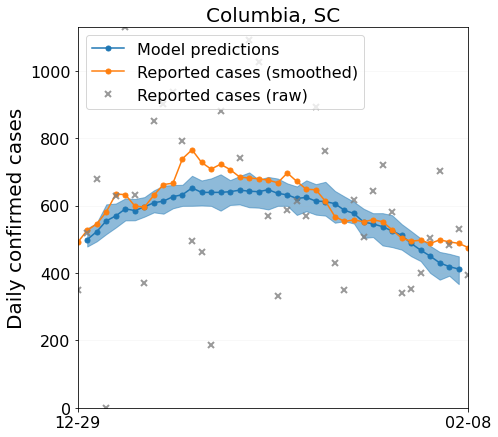

,timestring,data_kwargs,model_kwargs,results,experiment_to_run,final infected fraction,loss_dict_eval_start_time_cases,loss_dict_eval_end_time_cases,loss_dict_cumulative_predicted_cases,loss_dict_cumulative_true_cases,loss_dict_cumulative_cases_RMSE,loss_dict_cumulative_cases_MSE,loss_dict_daily_cases_RMSE,loss_dict_daily_cases_MSE,loss_dict_daily_cases_RMSE_time_varying_cdr,loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr,loss_dict_daily_cases_MRE_thres-1_sum,loss_dict_daily_cases_MRE_thres-10_sum,loss_dict_daily_cases_MRE_thres-20_sum,loss_dict_daily_cases_MRE_thres-50_sum,loss_dict_daily_cases_MRE_thres-100_sum,loss_dict_daily_cases_poisson_NLL_thres-1_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-1_sum,loss_dict_daily_cases_poisson_NLL_thres-10_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-10_sum,...,agg_county_loss_dict_max_daily_deaths_RMSE,agg_county_loss_dict_unweighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_weighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_max_daily_deaths_per_capita_RMSE,home_beta,poi_psi,p_sick_at_t0,inter_cbg_gamma,just_compute_r0,min_datetime,max_datetime,model_init_kwargs,simulation_kwargs,poi_attributes_to_clip,include_cbg_prop_out,include_inter_cbg_travel,include_mask_use,counties_to_track,poi_cbg_visits_list,poi_ids,cbg_ids,MSA_name,start_beta,end_beta,beta_ratio
931,2021_11_28_12_33_55_506980_normal_grid_search_normal_grid_search,"{'MSA_name': 'Columbia_SC', 'nrows': None}","{'min_datetime': 2020-12-20 00:00:00, 'max_datetime': 2021-01-29 23:00:00, 'exogenous_model_kwar...",None,normal_grid_search,"[0.13771313415446945, 0.13493064775989377, 0.13778188287527093, 0.13634655652876687, 0.136392738...",2020-12-29,2021-02-07,"[[43057.2, 43521.6, 44023.2, 44526.6, 45083.4, 45648.6, 46227.6, 46795.799999999996, 47398.2, 47...","[48961, 49481, 50161, 50161, 50790, 51919, 52550, 52920, 53772, 54672, 55610, 56401, 56895, 5735...",7952.232871,6.331378e+07,248.782602,61922.315,237.240052,53.53417,0.272384,0.272384,0.272384,0.272384,0.272384,1796.159902,58513.703102,1796.159902,58513.703102,...,3.836764,0.000023,0.000013,0.000043,"[0.014666666666666666, 0.014483333333333332, 0.0143, 0.014116666666666666, 0.013933333333333332,...",11.785714,None,None,False,2020-12-20,2021-01-29 23:00:00,{'num_seeds': 30},"{'use_aggregate_mobility': False, 'use_home_proportion_beta': False, 'use_inter_cbg_leak_factor'...","{'clip_areas': True, 'clip_dwell_times': True, 'clip_visits': True}",False,False,True,"[45081, 45017, 45063, 45055, 45039, 45079]",None,None,None,Columbia_SC,0.014667,0.007333,0.5


In [260]:
# Good! 

print(best_models_df[['home_beta', 'poi_psi']])
print(best_models_df['home_beta'].iloc[0].min(), best_models_df['home_beta'].iloc[0].max())

fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
plt.show()

best_models_df

                                                                                              home_beta    poi_psi
20  [0.015333333333333332, 0.01510972222222222, 0.01488611111111111, 0.014662499999999998, 0.0144388...  11.666667
0.006388888888888888 0.015333333333333332
Plotting predictions from 1 models
Applying time-varying CDR to visualization


/media/gpu/easystore/covid-mobility-tool/model_experiments.py:2811: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(real_dates, real_data, marker='x', c='grey', alpha=0.8,


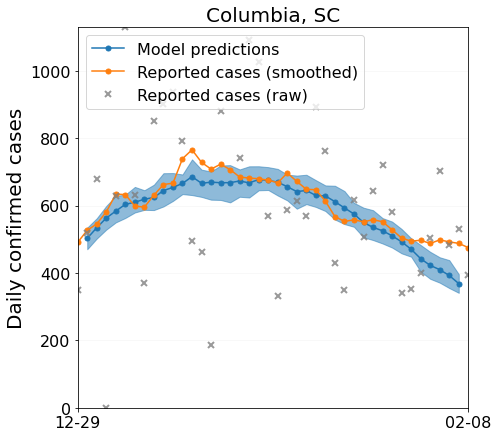

,timestring,data_kwargs,model_kwargs,results,experiment_to_run,final infected fraction,loss_dict_eval_start_time_cases,loss_dict_eval_end_time_cases,loss_dict_cumulative_predicted_cases,loss_dict_cumulative_true_cases,loss_dict_cumulative_cases_RMSE,loss_dict_cumulative_cases_MSE,loss_dict_daily_cases_RMSE,loss_dict_daily_cases_MSE,loss_dict_daily_cases_RMSE_time_varying_cdr,loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr,loss_dict_daily_cases_MRE_thres-1_sum,loss_dict_daily_cases_MRE_thres-10_sum,loss_dict_daily_cases_MRE_thres-20_sum,loss_dict_daily_cases_MRE_thres-50_sum,loss_dict_daily_cases_MRE_thres-100_sum,loss_dict_daily_cases_poisson_NLL_thres-1_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-1_sum,loss_dict_daily_cases_poisson_NLL_thres-10_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-10_sum,...,agg_county_loss_dict_max_daily_deaths_RMSE,agg_county_loss_dict_unweighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_weighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_max_daily_deaths_per_capita_RMSE,home_beta,poi_psi,p_sick_at_t0,inter_cbg_gamma,just_compute_r0,min_datetime,max_datetime,model_init_kwargs,simulation_kwargs,poi_attributes_to_clip,include_cbg_prop_out,include_inter_cbg_travel,include_mask_use,counties_to_track,poi_cbg_visits_list,poi_ids,cbg_ids,MSA_name,start_beta,end_beta,beta_ratio
20,2021_11_28_13_30_17_509206_normal_grid_search_normal_grid_search,"{'MSA_name': 'Columbia_SC', 'nrows': None}","{'min_datetime': 2020-12-20 00:00:00, 'max_datetime': 2021-01-29 23:00:00, 'exogenous_model_kwar...",None,normal_grid_search,"[0.13768269578953446, 0.13730169142845147, 0.13819385040068433, 0.13711538764307343, 0.136989435...",2020-12-29,2021-02-07,"[[43064.4, 43529.4, 44026.2, 44531.4, 45081.0, 45676.799999999996, 46252.2, 46811.4, 47425.2, 48...","[48961, 49481, 50161, 50161, 50790, 51919, 52550, 52920, 53772, 54672, 55610, 56401, 56895, 5735...",7591.910768,5.768706e+07,245.257384,60172.0213,235.526693,48.662176,0.278464,0.278464,0.278464,0.278464,0.278464,1681.522608,56976.163377,1681.522608,56976.163377,...,3.816624,0.000023,0.000013,0.000043,"[0.015333333333333332, 0.01510972222222222, 0.01488611111111111, 0.014662499999999998, 0.0144388...",11.666667,None,None,False,2020-12-20,2021-01-29 23:00:00,{'num_seeds': 30},"{'use_aggregate_mobility': False, 'use_home_proportion_beta': False, 'use_inter_cbg_leak_factor'...","{'clip_areas': True, 'clip_dwell_times': True, 'clip_visits': True}",False,False,True,"[45017, 45079, 45055, 45063, 45081, 45039]",None,None,None,Columbia_SC,0.015333,0.006389,0.416667


In [304]:
# Good! Group 5
max_timestring = '2021_11_28_13_44_203770'  # group 5  GOOD:  # 2021_11_28_13_18_45_911113_normal_grid_search_normal_grid_search
min_timestring = '2021_11_28_13_23_203770' 

# Loading models with timestrings between 2021_11_28_13_15_203770 and 2021_11_28_13_25_203770

print(best_models_df[['home_beta', 'poi_psi']])
print(best_models_df['home_beta'].iloc[0].min(), best_models_df['home_beta'].iloc[0].max())

fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
plt.show()

best_models_df

In [223]:
# best_models_df.head(5)
print(best_models_df[['home_beta', 'poi_psi']])

                                                                                               home_beta    poi_psi
296  [0.013388888888888888, 0.013221527777777776, 0.013054166666666665, 0.012886805555555554, 0.01271...  16.428571
413  [0.013388888888888888, 0.013305208333333332, 0.013221527777777776, 0.013137847222222221, 0.01305...  10.000000


In [242]:
bt = best_models_df['home_beta'].iloc[0]
bt.min()

0.011

In [246]:
best_models_df

,timestring,data_kwargs,model_kwargs,results,experiment_to_run,final infected fraction,loss_dict_eval_start_time_cases,loss_dict_eval_end_time_cases,loss_dict_cumulative_predicted_cases,loss_dict_cumulative_true_cases,loss_dict_cumulative_cases_RMSE,loss_dict_cumulative_cases_MSE,loss_dict_daily_cases_RMSE,loss_dict_daily_cases_MSE,loss_dict_daily_cases_RMSE_time_varying_cdr,loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr,loss_dict_daily_cases_MRE_thres-1_sum,loss_dict_daily_cases_MRE_thres-10_sum,loss_dict_daily_cases_MRE_thres-20_sum,loss_dict_daily_cases_MRE_thres-50_sum,loss_dict_daily_cases_MRE_thres-100_sum,loss_dict_daily_cases_poisson_NLL_thres-1_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-1_sum,loss_dict_daily_cases_poisson_NLL_thres-10_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-10_sum,...,agg_county_loss_dict_max_daily_deaths_RMSE,agg_county_loss_dict_unweighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_weighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_max_daily_deaths_per_capita_RMSE,home_beta,poi_psi,p_sick_at_t0,inter_cbg_gamma,just_compute_r0,min_datetime,max_datetime,model_init_kwargs,simulation_kwargs,poi_attributes_to_clip,include_cbg_prop_out,include_inter_cbg_travel,include_mask_use,counties_to_track,poi_cbg_visits_list,poi_ids,cbg_ids,MSA_name,start_beta,end_beta,beta_ratio
935,2021_11_28_12_33_55_506980_normal_grid_search_normal_grid_search,"{'MSA_name': 'Columbia_SC', 'nrows': None}","{'min_datetime': 2020-12-20 00:00:00, 'max_datetime': 2021-01-29 23:00:00, 'exogenous_model_kwar...",None,normal_grid_search,"[0.13771313415446945, 0.13493064775989377, 0.13778188287527093, 0.13634655652876687, 0.136392738...",2020-12-29,2021-02-07,"[[43057.2, 43521.6, 44023.2, 44526.6, 45083.4, 45648.6, 46227.6, 46795.799999999996, 47398.2, 47...","[48961, 49481, 50161, 50161, 50790, 51919, 52550, 52920, 53772, 54672, 55610, 56401, 56895, 5735...",7952.232871,6.331378e+07,248.782602,61922.315,237.240052,53.53417,0.272384,0.272384,0.272384,0.272384,0.272384,1796.159902,58513.703102,1796.159902,58513.703102,...,3.836764,0.000023,0.000013,0.000043,"[0.014666666666666666, 0.014483333333333332, 0.0143, 0.014116666666666666, 0.013933333333333332,...",11.785714,None,None,False,2020-12-20,2021-01-29 23:00:00,{'num_seeds': 30},"{'use_aggregate_mobility': False, 'use_home_proportion_beta': False, 'use_inter_cbg_leak_factor'...","{'clip_areas': True, 'clip_dwell_times': True, 'clip_visits': True}",False,False,True,"[45081, 45017, 45063, 45055, 45039, 45079]",None,None,None,Columbia_SC,0.014667,0.007333,0.5


In [155]:
best_models_df['timestring']

121    2021_11_27_20_12_56_761158_normal_grid_search_normal_grid_search
Name: timestring, dtype: object

In [21]:
plt.show()

Loading models with timestrings between 2021_01_17_12_40_34_684920 and 2021_01_17_13_13_33_579485
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 280 fitted models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Time to load and score all models: 1.022s -> 0.004s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Washington_Arlington_Alexandria_DC_VA_MD_WV: 3 within loss tol -> keeping 3
Plotting predictions from 3 models
Applying time-varying CDR to visualization


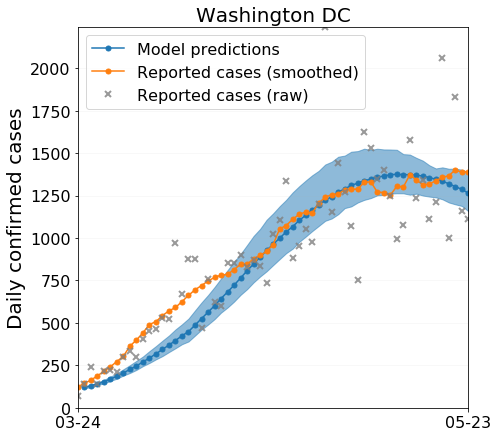

In [14]:
# no mobility model
min_timestring = '2021_01_17_12_40_34_684920'
max_timestring = '2021_01_17_13_13_33_579485'
expected_num_jobs = 280
no_mobility_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                    min_timestring=min_timestring,
                                                    max_timestring=max_timestring, 
                                                    required_properties={'experiment_to_run':'grid_search_no_mobility'})
assert len(no_mobility_df) == expected_num_jobs, len(no_mobility_df)
no_mobility_df['MSA_name'] = no_mobility_df['data_kwargs'].map(lambda x:x['MSA_name'])
no_mobility_df['start_beta'] = no_mobility_df['home_beta'].apply(lambda x:x[0])
no_mobility_df['end_beta'] = no_mobility_df['home_beta'].apply(lambda x:x[-1])
no_mobility_df['beta_ratio'] = no_mobility_df.end_beta.values / no_mobility_df.start_beta.values

best_models_df = get_best_models_for_all_msas(no_mobility_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)

In [1]:
## 




Loading models with timestrings between 2021_01_17_08_21_33_262803 and 2021_01_17_10_28_05_182850
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 1050 fitted models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Time to load and score all models: 3.866s -> 0.004s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Washington_Arlington_Alexandria_DC_VA_MD_WV: 15 within loss tol -> keeping 15
Plotting predictions from 15 models
Applying time-varying CDR to visualization


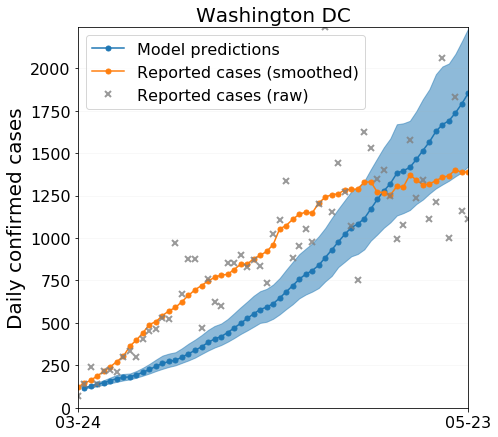

In [16]:
# no mask model
min_timestring = '2021_01_17_08_21_33_262803'
max_timestring = '2021_01_17_10_28_05_182850'
expected_num_jobs = 1050
no_mask_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                min_timestring=min_timestring,
                                                max_timestring=max_timestring, 
                                                required_properties={'experiment_to_run':'grid_search_no_mask_data'})
assert len(no_mask_df) == expected_num_jobs, len(no_mask_df)

no_mask_df['MSA_name'] = no_mask_df['data_kwargs'].map(lambda x:x['MSA_name'])
no_mask_df['start_beta'] = no_mask_df['home_beta'].apply(lambda x:x[0])
no_mask_df['end_beta'] = no_mask_df['home_beta'].apply(lambda x:x[-1])
no_mask_df['beta_ratio'] = no_mask_df.end_beta.values / no_mask_df.start_beta.values

best_models_df = get_best_models_for_all_msas(no_mask_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)

Loading models with timestrings between 2021_01_17_11_19_21_297270 and 2021_01_17_12_13_11_582406
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 450 fitted models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Time to load and score all models: 1.399s -> 0.003s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Washington_Arlington_Alexandria_DC_VA_MD_WV: 5 within loss tol -> keeping 5
Plotting predictions from 5 models
Applying time-varying CDR to visualization


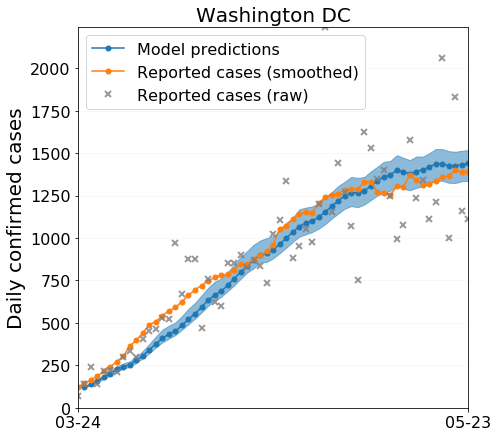

In [17]:
# fixed beta_base over time
min_timestring = '2021_01_17_11_19_21_297270'
max_timestring = '2021_01_17_12_13_11_582406'
expected_num_jobs = 450
fixed_beta_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                   min_timestring=min_timestring,
                                                   max_timestring=max_timestring, 
                                                   required_properties={'experiment_to_run':'grid_search_fixed_beta'})
assert len(fixed_beta_df) == expected_num_jobs, len(fixed_beta_df)
fixed_beta_df['MSA_name'] = fixed_beta_df['data_kwargs'].map(lambda x:x['MSA_name'])
fixed_beta_df['start_beta'] = fixed_beta_df['home_beta']

best_models_df = get_best_models_for_all_msas(fixed_beta_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)

full
Plotting predictions from 5 models
Applying time-varying CDR to visualization
Plotting predictions from 6 models
Applying time-varying CDR to visualization
no mobility
Plotting predictions from 3 models
Applying time-varying CDR to visualization
Plotting predictions from 5 models
Applying time-varying CDR to visualization
no mask
Plotting predictions from 15 models
Applying time-varying CDR to visualization
Plotting predictions from 10 models
Applying time-varying CDR to visualization
fixed beta


/dfs/scratch1/safegraph_homes/safegraph_env_v3/safegraph_env_v3/lib/python3.7/site-packages/pandas/core/series.py:951: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Plotting predictions from 5 models
Applying time-varying CDR to visualization
Plotting predictions from 3 models
Applying time-varying CDR to visualization


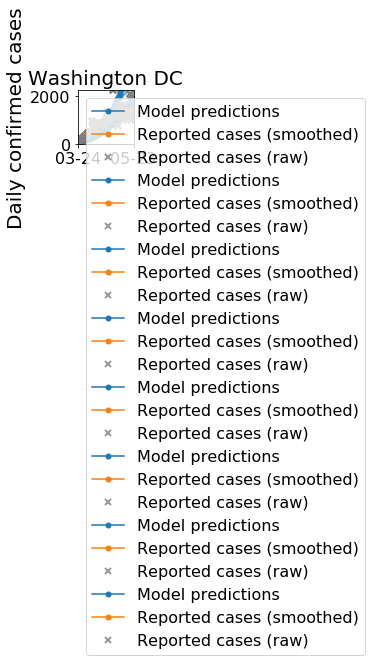

In [18]:
full_loss_key = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'
train_loss_key = 'train_' + full_loss_key
test_loss_key = 'test_' + full_loss_key
loss_tol = 1.2
fig, ax = plt.subplots(figsize=(1,1))
all_results = []
for label, df in [('full', gridsearch_df), ('no mobility', no_mobility_df), 
                  ('no mask', no_mask_df), ('fixed beta', fixed_beta_df), ]:
    print(label)
    results = {'model':label}
    # sort by full loss, eval full loss
    best_models_df = get_best_models_for_all_msas(df, full_loss_key, loss_tolerance=loss_tol, verbose=False)
    msa_best_models = best_models_df.sort_values(by=full_loss_key)
    results['full_loss_n_models'] = len(best_models_df)
    params = ['poi_psi', 'start_beta', 'beta_ratio']
    means = msa_best_models.mean()[params]
    mins = msa_best_models.min()[params]
    maxes = msa_best_models.max()[params]
    for p in params:
        results[p] = '%.3f (%.3f-%.3f)' % (means[p], mins[p], maxes[p])
    score_dict = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
    real_data = score_dict['smoothed_real_data']
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                     score_dict['real_dates'], real_data)
    results['full_loss_of_mean'] = rmse_of_mean
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                     score_dict['real_dates'], real_data, normalized=True)
    results['normalized_full_loss_of_mean'] = rmse_of_mean

    # sort by train loss, eval test loss
    best_models_df = get_best_models_for_all_msas(df, train_loss_key, loss_tolerance=loss_tol, verbose=False)
    msa_best_models = best_models_df.sort_values(by=train_loss_key)
    results['train_loss_n_models'] = len(msa_best_models)
    score_dict = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
    real_data = score_dict['smoothed_real_data']
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                         score_dict['real_dates'], real_data,
                                         train_test_partition=datetime.datetime(2020, 5, 1))
    results['test_loss_of_mean'] = rmse_of_mean
    all_results.append(results)

In [19]:
cols = list(all_results[-1].keys())
first_wave_df = pd.DataFrame(all_results, columns=cols)
first_wave_df.round(3)

,model,full_loss_n_models,poi_psi,start_beta,beta_ratio,full_loss_of_mean,normalized_full_loss_of_mean,train_loss_n_models,test_loss_of_mean
0,full,5,4803.168 (3051.755-6204.298),0.015 (0.011-0.019),0.860 (0.800-1.000),63.607,0.069,6,57.545
1,no mobility,3,0.000 (0.000-0.000),0.025 (0.023-0.026),0.800 (0.700-0.900),105.462,0.114,5,112.879
2,no mask,15,3939.138 (1300.343-6204.298),0.011 (0.006-0.016),0.747 (0.700-0.900),283.071,0.306,10,1270.573
3,fixed beta,5,4943.281 (4102.603-6204.298),0.014 (0.011-0.015),nan (nan-nan),83.133,0.090,3,152.515


## Washington DC, second wave (Table 2, Figure 4, Table A2)

In [20]:
msa_name = 'Washington_Arlington_Alexandria_DC_VA_MD_WV'
key_to_sort_by = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'
min_datetime = datetime.datetime(2020, 11, 1)
max_datetime = datetime.datetime(2020, 12, 31)

Loading models with timestrings between 2021_01_19_10_48_52_008132 and 2021_01_19_17_02_36_029096
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 1050 fitted models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Time to load and score all models: 3.557s -> 0.003s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Washington_Arlington_Alexandria_DC_VA_MD_WV: 7 within loss tol -> keeping 7
Plotting predictions from 7 models
Applying time-varying CDR to visualization


(900, 3439.0)

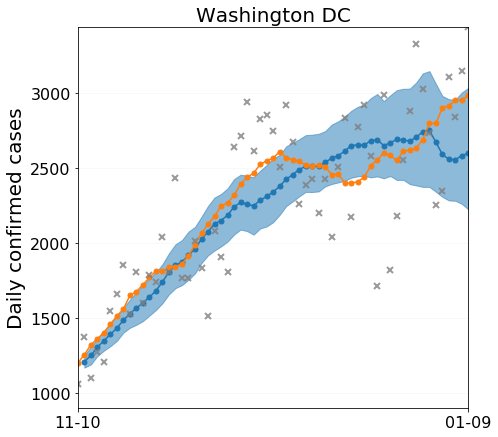

In [21]:
# full model
min_timestring = '2021_01_19_10_48_52_008132'
max_timestring = '2021_01_19_17_02_36_029096'
expected_num_jobs = 1050
gridsearch_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                   min_timestring=min_timestring,
                                                   max_timestring=max_timestring, 
                                                   required_properties={'experiment_to_run':'normal_grid_search'})
assert len(gridsearch_df) == expected_num_jobs, len(gridsearch_df)
gridsearch_df['MSA_name'] = gridsearch_df['data_kwargs'].map(lambda x:x['MSA_name'])
gridsearch_df['start_beta'] = gridsearch_df['home_beta'].apply(lambda x:x[0])
gridsearch_df['end_beta'] = gridsearch_df['home_beta'].apply(lambda x:x[-1])
gridsearch_df['beta_ratio'] = gridsearch_df.end_beta.values / gridsearch_df.start_beta.values

best_models_df = get_best_models_for_all_msas(gridsearch_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime, additional_kwargs={'plot_legend':False})
ymin, ymax = ax.get_ylim()
ax.set_ylim(900, ymax)

Loading models with timestrings between 2021_01_19_19_59_26_267351 and 2021_01_19_23_32_59_814482
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 280 fitted models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Time to load and score all models: 1.582s -> 0.006s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Washington_Arlington_Alexandria_DC_VA_MD_WV: 2 within loss tol -> keeping 2
Plotting predictions from 2 models
Applying time-varying CDR to visualization


(900, 3439.0)

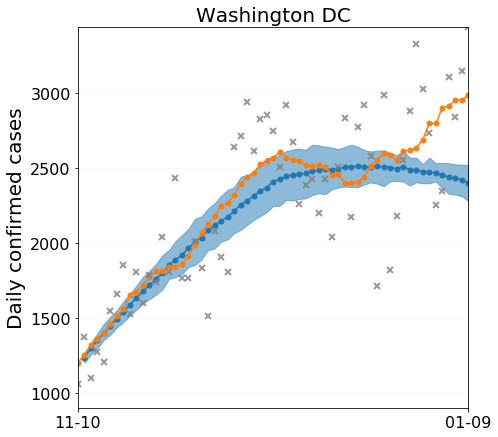

In [22]:
# no mobility model
min_timestring = '2021_01_19_19_59_26_267351'
max_timestring = '2021_01_19_23_32_59_814482'
expected_num_jobs = 280
no_mobility_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                min_timestring=min_timestring,
                                                max_timestring=max_timestring, 
                                                required_properties={'experiment_to_run':'grid_search_no_mobility'})
assert len(no_mobility_df) == expected_num_jobs, len(no_mobility_df)
no_mobility_df['MSA_name'] = no_mobility_df['data_kwargs'].map(lambda x:x['MSA_name'])
no_mobility_df['start_beta'] = no_mobility_df['home_beta'].apply(lambda x:x[0])
no_mobility_df['end_beta'] = no_mobility_df['home_beta'].apply(lambda x:x[-1])
no_mobility_df['beta_ratio'] = no_mobility_df.end_beta.values / no_mobility_df.start_beta.values

best_models_df = get_best_models_for_all_msas(no_mobility_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime, additional_kwargs={'plot_legend':False})
ymin, ymax = ax.get_ylim()
ax.set_ylim(900, ymax)

Loading models with timestrings between 2021_01_19_19_59_26_267351 and 2021_01_19_22_05_45_370495
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 1050 fitted models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Time to load and score all models: 3.466s -> 0.003s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Washington_Arlington_Alexandria_DC_VA_MD_WV: 1 within loss tol -> keeping 1
Plotting predictions from 1 models
Applying time-varying CDR to visualization


(900, 3439.0)

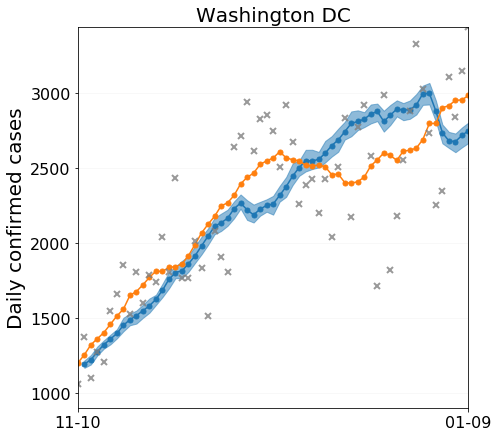

In [23]:
# no mask model
min_timestring = '2021_01_19_19_59_26_267351'
max_timestring = '2021_01_19_22_05_45_370495'
expected_num_jobs = 1050
no_mask_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                min_timestring=min_timestring,
                                                max_timestring=max_timestring, 
                                                required_properties={'experiment_to_run':'grid_search_no_mask_data'})
assert len(no_mask_df) == expected_num_jobs, len(no_mask_df)
no_mask_df['MSA_name'] = no_mask_df['data_kwargs'].map(lambda x:x['MSA_name'])
no_mask_df['start_beta'] = no_mask_df['home_beta'].apply(lambda x:x[0])
no_mask_df['end_beta'] = no_mask_df['home_beta'].apply(lambda x:x[-1])
no_mask_df['beta_ratio'] = no_mask_df.end_beta.values / no_mask_df.start_beta.values

best_models_df = get_best_models_for_all_msas(no_mask_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime, additional_kwargs={'plot_legend':False})
ymin, ymax = ax.get_ylim()
ax.set_ylim(900, ymax)

Loading models with timestrings between 2021_01_19_19_59_26_267351 and 2021_01_21_22_39_41_407608
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 450 fitted models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Time to load and score all models: 1.519s -> 0.003s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Washington_Arlington_Alexandria_DC_VA_MD_WV: 1 within loss tol -> keeping 1
Plotting predictions from 1 models
Applying time-varying CDR to visualization


(900, 3439.0)

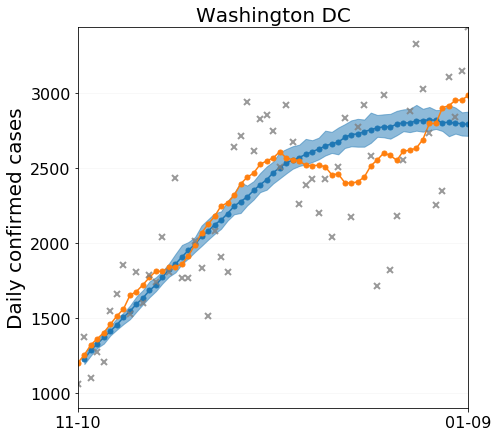

In [24]:
# fixed beta over time
min_timestring = '2021_01_19_19_59_26_267351'
max_timestring = '2021_01_21_22_39_41_407608'
expected_num_jobs = 450
fixed_beta_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                   min_timestring=min_timestring,
                                                   max_timestring=max_timestring, 
                                                   required_properties={'experiment_to_run':'grid_search_fixed_beta'})
assert len(fixed_beta_df) == expected_num_jobs, len(fixed_beta_df)
fixed_beta_df['MSA_name'] = fixed_beta_df['data_kwargs'].map(lambda x:x['MSA_name'])
fixed_beta_df['start_beta'] = fixed_beta_df['home_beta']

best_models_df = get_best_models_for_all_msas(fixed_beta_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime, additional_kwargs={'plot_legend':False})
ymin, ymax = ax.get_ylim()
ax.set_ylim(900, ymax)

full
Plotting predictions from 7 models
Applying time-varying CDR to visualization
Plotting predictions from 2 models
Applying time-varying CDR to visualization
no mobility
Plotting predictions from 2 models
Applying time-varying CDR to visualization
Plotting predictions from 1 models
Applying time-varying CDR to visualization
no mask
Plotting predictions from 1 models
Applying time-varying CDR to visualization
Plotting predictions from 2 models
Applying time-varying CDR to visualization
fixed beta
Plotting predictions from 1 models
Applying time-varying CDR to visualization
Plotting predictions from 3 models
Applying time-varying CDR to visualization


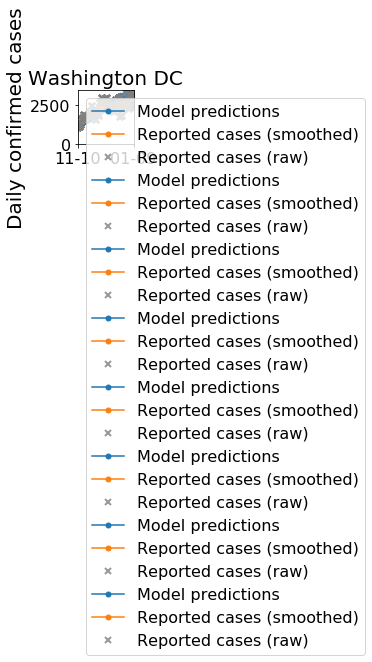

In [25]:
full_loss_key = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'
train_loss_key = 'train_' + full_loss_key
test_loss_key = 'test_' + full_loss_key
loss_tol = 1.2
fig, ax = plt.subplots(figsize=(1,1))
all_results = []
for label, df in [('full', gridsearch_df), ('no mobility', no_mobility_df), 
                  ('no mask', no_mask_df), ('fixed beta', fixed_beta_df), ]:
    print(label)
    results = {'model':label}
    # sort by full loss, eval full loss
    best_models_df = get_best_models_for_all_msas(df, full_loss_key, loss_tolerance=loss_tol, verbose=False)
    msa_best_models = best_models_df.sort_values(by=full_loss_key)
    results['full_loss_n_models'] = len(best_models_df)
    params = ['poi_psi', 'start_beta', 'beta_ratio']
    means = msa_best_models.mean()[params]
    mins = msa_best_models.min()[params]
    maxes = msa_best_models.max()[params]
    for p in params:
        results[p] = '%.3f (%.3f-%.3f)' % (means[p], mins[p], maxes[p])
    score_dict = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
    real_data = score_dict['smoothed_real_data']
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                     score_dict['real_dates'], real_data)
    results['full_loss_of_mean'] = rmse_of_mean
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                     score_dict['real_dates'], real_data, normalized=True)
    results['normalized_full_loss_of_mean'] = rmse_of_mean

    # sort by train loss, eval test loss
    best_models_df = get_best_models_for_all_msas(df, train_loss_key, loss_tolerance=loss_tol, verbose=False)
    msa_best_models = best_models_df.sort_values(by=train_loss_key)
    results['train_loss_n_models'] = len(msa_best_models)
    score_dict = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
    real_data = score_dict['smoothed_real_data']
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                         score_dict['real_dates'], real_data,
                                         train_test_partition=datetime.datetime(2020, 12, 18))
    results['test_loss_of_mean'] = rmse_of_mean
    all_results.append(results)

In [26]:
cols = list(all_results[-1].keys())
second_wave_df = pd.DataFrame(all_results, columns=cols)
second_wave_df.round(3)

,model,full_loss_n_models,poi_psi,start_beta,beta_ratio,full_loss_of_mean,normalized_full_loss_of_mean,train_loss_n_models,test_loss_of_mean
0,full,7,5415.976 (628.315-10403.123),0.029 (0.015-0.045),1.043 (0.900-1.300),158.535,0.070,2,276.636
1,no mobility,2,0.000 (0.000-0.000),0.044 (0.043-0.045),0.950 (0.900-1.000),181.968,0.080,1,299.640
2,no mask,1,3421.117 (3421.117-3421.117),0.009 (0.009-0.009),0.900 (0.900-0.900),209.500,0.092,2,404.530
3,fixed beta,1,628.315 (628.315-628.315),0.043 (0.043-0.043),nan (nan-nan),139.311,0.061,3,257.198


## Richmond and Eastern, second wave (Table 2, Figure 3)

Loading models with timestrings between 2021_01_19_10_48_52_008132 and 2021_01_19_17_02_36_029096
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 1050 fitted models for Richmond_VA
Time to load and score all models: 3.966s -> 0.004s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Richmond_VA: 1 within loss tol -> keeping 1
Plotting predictions from 1 models
Applying time-varying CDR to visualization


(80, 816.0)

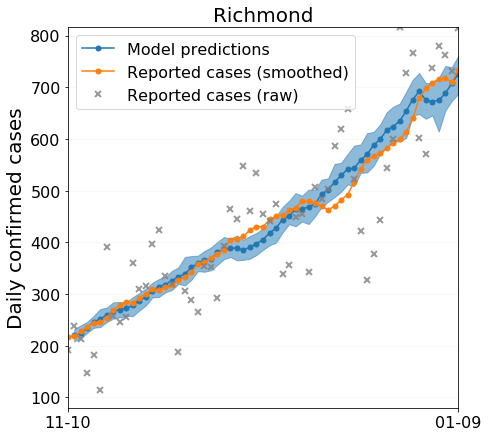

In [27]:
msa_name = 'Richmond_VA'
key_to_sort_by = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'
min_datetime = datetime.datetime(2020, 11, 1)
max_datetime = datetime.datetime(2020, 12, 31)

min_timestring = '2021_01_19_10_48_52_008132'
max_timestring = '2021_01_19_17_02_36_029096'
expected_num_jobs = 1050
richmond_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                 min_timestring=min_timestring,
                                                 max_timestring=max_timestring, 
                                                 required_properties={'experiment_to_run':'normal_grid_search'})
assert len(richmond_df) == expected_num_jobs, len(richmond_df)
richmond_df['MSA_name'] = richmond_df['data_kwargs'].map(lambda x:x['MSA_name'])
richmond_df['start_beta'] = richmond_df['home_beta'].apply(lambda x:x[0])
richmond_df['end_beta'] = richmond_df['home_beta'].apply(lambda x:x[-1])
richmond_df['beta_ratio'] = richmond_df.end_beta.values / richmond_df.start_beta.values

best_models_df = get_best_models_for_all_msas(richmond_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
ymin, ymax = ax.get_ylim()
ax.set_ylim(80, ymax)

Loading models with timestrings between 2021_01_19_10_48_52_008132 and 2021_01_19_17_02_36_029096
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 1050 fitted models for Virginia_Beach_Norfolk_Newport_News_VA_NC
Time to load and score all models: 3.270s -> 0.003s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Virginia_Beach_Norfolk_Newport_News_VA_NC: 1 within loss tol -> keeping 1
Plotting predictions from 1 models
Applying time-varying CDR to visualization


(80, 1297.0)

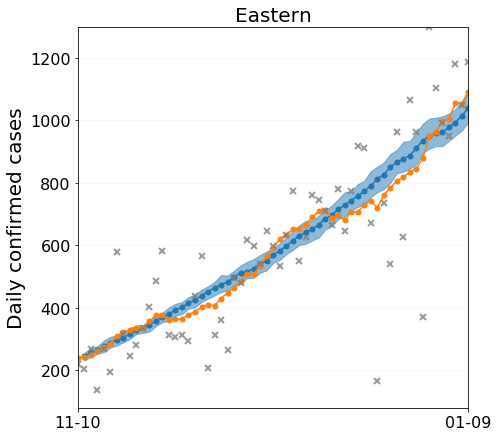

In [28]:
msa_name = 'Virginia_Beach_Norfolk_Newport_News_VA_NC'
key_to_sort_by = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'
min_datetime = datetime.datetime(2020, 11, 1)
max_datetime = datetime.datetime(2020, 12, 31)

min_timestring = '2021_01_19_10_48_52_008132'
max_timestring = '2021_01_19_17_02_36_029096'
expected_num_jobs = 1050
eastern_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                min_timestring=min_timestring,
                                                max_timestring=max_timestring, 
                                                required_properties={'experiment_to_run':'normal_grid_search'})
assert len(eastern_df) == expected_num_jobs, len(eastern_df)
eastern_df['MSA_name'] = eastern_df['data_kwargs'].map(lambda x:x['MSA_name'])
eastern_df['start_beta'] = eastern_df['home_beta'].apply(lambda x:x[0])
eastern_df['end_beta'] = eastern_df['home_beta'].apply(lambda x:x[-1])
eastern_df['beta_ratio'] = eastern_df.end_beta.values / eastern_df.start_beta.values

best_models_df = get_best_models_for_all_msas(eastern_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime, additional_kwargs={'plot_legend':False})
ymin, ymax = ax.get_ylim()
ax.set_ylim(80, ymax)

Richmond_VA
Plotting predictions from 1 models
Applying time-varying CDR to visualization
Plotting predictions from 2 models
Applying time-varying CDR to visualization
Virginia_Beach_Norfolk_Newport_News_VA_NC
Plotting predictions from 1 models
Applying time-varying CDR to visualization
Plotting predictions from 1 models
Applying time-varying CDR to visualization


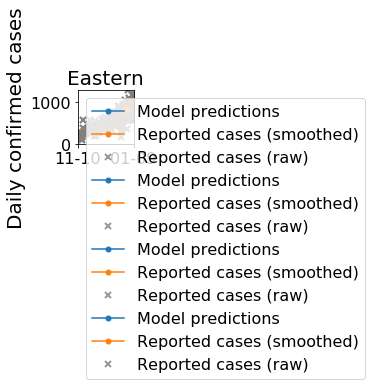

In [29]:
full_loss_key = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'
train_loss_key = 'train_' + full_loss_key
test_loss_key = 'test_' + full_loss_key
loss_tol = 1.2
fig, ax = plt.subplots(figsize=(1,1))
all_results = []
for msa_name, df in [('Richmond_VA', richmond_df), ('Virginia_Beach_Norfolk_Newport_News_VA_NC', eastern_df)]:
    print(msa_name)
    results = {'msa':MSAS_TO_PRETTY_NAMES[msa_name]}
    # sort by full loss, eval full loss
    best_models_df = get_best_models_for_all_msas(df, full_loss_key, loss_tolerance=loss_tol, verbose=False)
    msa_best_models = best_models_df.sort_values(by=full_loss_key)
    results['full_loss_n_models'] = len(best_models_df)
    params = ['poi_psi', 'start_beta', 'beta_ratio']
    means = msa_best_models.mean()[params]
    mins = msa_best_models.min()[params]
    maxes = msa_best_models.max()[params]
    for p in params:
        results[p] = '%.3f (%.3f-%.3f)' % (means[p], mins[p], maxes[p])
    score_dict = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
    real_data = score_dict['smoothed_real_data']
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                     score_dict['real_dates'], real_data)
    results['full_loss_of_mean'] = rmse_of_mean
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                     score_dict['real_dates'], real_data, normalized=True)
    results['normalized_full_loss_of_mean'] = rmse_of_mean

    # sort by train loss, eval test loss
    best_models_df = get_best_models_for_all_msas(df, train_loss_key, loss_tolerance=loss_tol, verbose=False)
    msa_best_models = best_models_df.sort_values(by=train_loss_key)
    results['train_loss_n_models'] = len(msa_best_models)
    score_dict = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
    real_data = score_dict['smoothed_real_data']
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                         score_dict['real_dates'], real_data,
                                         train_test_partition=datetime.datetime(2020, 12, 18))
    results['test_loss_of_mean'] = rmse_of_mean
    all_results.append(results)

In [30]:
cols = list(all_results[-1].keys())
second_wave_df = pd.DataFrame(all_results, columns=cols)
second_wave_df.round(3)

,msa,full_loss_n_models,poi_psi,start_beta,beta_ratio,full_loss_of_mean,normalized_full_loss_of_mean,train_loss_n_models,test_loss_of_mean
0,Richmond,1,3421.117 (3421.117-3421.117),0.027 (0.027-0.027),1.300 (1.300-1.300),21.930,0.049,2,53.272
1,Eastern,1,2024.716 (2024.716-2024.716),0.033 (0.033-0.033),1.200 (1.200-1.200),37.391,0.063,1,49.394


# 3. Use cases

## SES disparities over time (Figure 5)

In [264]:
# msa_name = 'Washington_Arlington_Alexandria_DC_VA_MD_WV'
msa_name = 'Columbia_SC'
key_to_sort_by = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'

min_timestring = '2021_01_16_15_27_26_107791'
max_timestring = '2021_11_16_17_36_28_098096'
expected_num_jobs = 1050
gridsearch_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                   min_timestring=min_timestring,
                                                   max_timestring=max_timestring, 
                                                   required_properties={'experiment_to_run':'normal_grid_search'})
assert len(gridsearch_df) == expected_num_jobs, len(gridsearch_df)
gridsearch_df['MSA_name'] = gridsearch_df['data_kwargs'].map(lambda x:x['MSA_name'])
best_models_df = get_best_models_for_all_msas(gridsearch_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
first_wave_models = best_models_df.sort_values(by=key_to_sort_by)

min_timestring = '2021_01_19_10_48_52_008132'
max_timestring = '2021_11_19_17_02_36_029096'
expected_num_jobs = 1050
gridsearch_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                   min_timestring=min_timestring,
                                                   max_timestring=max_timestring, 
                                                   required_properties={'experiment_to_run':'normal_grid_search'})
assert len(gridsearch_df) == expected_num_jobs, len(gridsearch_df)
gridsearch_df['MSA_name'] = gridsearch_df['data_kwargs'].map(lambda x:x['MSA_name'])
best_models_df = get_best_models_for_all_msas(gridsearch_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
second_wave_models = best_models_df.sort_values(by=key_to_sort_by)

Loading models with timestrings between 2021_01_16_15_27_26_107791 and 2021_11_16_17_36_28_098096
4213 files in directory /media/gpu/Seagate/extra_safegraph_aggregate_models/data_and_model_configs
Found 0 fitted models for Columbia_SC


ZeroDivisionError: float division by zero

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

ax = axes[0]
mean = plot_lir_over_time_for_multiple_models(first_wave_models.timestring.values, ax, 'bottom income decile', 'darkorchid', group='median_household_income_bottom_decile')
print('Diff = %.2f; ratio = %.2f' % (mean[-1] - mean[0], mean[-1] / mean[0]))
mean = plot_lir_over_time_for_multiple_models(first_wave_models.timestring.values, ax, 'top income decile', 'darkgoldenrod', group='median_household_income_top_decile')
print('Diff = %.2f; ratio = %.2f' % (mean[-1] - mean[0], mean[-1] / mean[0]))
mean = plot_lir_over_time_for_multiple_models(first_wave_models.timestring.values, ax, 'overall', 'tab:blue', group='all')
print('Diff = %.2f; ratio = %.2f' % (mean[-1] - mean[0], mean[-1] / mean[0]))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(mdates.SU, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax.legend(fontsize=16)
ax.grid(alpha=0.3)
ax.set_ylabel('Cumulative infections (per 100k pop)', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.tick_params(labelsize=16)
ax.set_title('Washington DC, first wave', fontsize=18)

ax = axes[1]
mean = plot_lir_over_time_for_multiple_models(second_wave_models.timestring.values, ax, 'bottom income decile', 'darkorchid', group='median_household_income_bottom_decile')
print('Diff = %.2f; ratio = %.2f' % (mean[-1] - mean[0], mean[-1] / mean[0]))
mean = plot_lir_over_time_for_multiple_models(second_wave_models.timestring.values, ax, 'top income decile', 'darkgoldenrod', group='median_household_income_top_decile')
print('Diff = %.2f; ratio = %.2f' % (mean[-1] - mean[0], mean[-1] / mean[0]))
mean = plot_lir_over_time_for_multiple_models(second_wave_models.timestring.values, ax, 'overall', 'tab:blue', group='all')
print('Diff = %.2f; ratio = %.2f' % (mean[-1] - mean[0], mean[-1] / mean[0]))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(mdates.SU, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax.grid(alpha=0.3)
ax.set_xlabel('Date', fontsize=16)
ax.tick_params(labelsize=16)
ax.set_title('Washington DC, second wave', fontsize=18)

Num params x seeds: 90
Diff = 4568.88; ratio = 1.51
Num params x seeds: 90
Diff = 7139.36; ratio = 1.78
Num params x seeds: 90
Diff = 5380.33; ratio = 1.59
Num params x seeds: 90
Diff = 4568.88; ratio = 1.51
Num params x seeds: 90
Diff = 7139.36; ratio = 1.78
Num params x seeds: 90
Diff = 5380.33; ratio = 1.59


Text(0.5, 1.0, 'Washington DC, second wave')

## Opening POI categories to different degrees (dashboard data)

In [15]:
model_timestrings, model_msas = filter_timestrings_for_properties(
            min_timestring='2021_01_29_10_08_16_729086',
            max_timestring='2021_12_01_01_02_55_384518',
            return_msa_names=True)
print('Found %d timestrings' % len(model_timestrings))
print(max(model_timestrings))
print(Counter(model_msas))

Loading models with timestrings between 2021_01_29_10_08_16_729086 and 2021_12_01_01_02_55_384518
6473 files in directory /media/gpu/Seagate/extra_safegraph_aggregate_models/data_and_model_configs
Found 4321 timestrings
2021_11_28_13_39_39_654223_normal_grid_search_normal_grid_search
Counter({'Columbia_SC': 4321})


In [10]:
# aggregate results over stochastic realizations per opening configuration
path_to_results = os.path.join(helper.FITTED_MODEL_DIR, 'model_results')
config2results = {}
groups = list(CATEGORY_GROUPS.keys())
for i, (msa_name, ts) in enumerate(zip(model_msas, model_timestrings)):
    if i % 1000 == 0:
        print(i)
    file = open(os.path.join(path_to_results, 'dashboard_results_%s.pkl' % ts), 'rb')
    config, num_visits, infection_results = pickle.load(file)
    file.close()
    config_key = [msa_name]
    for g in groups:
        first_cat = CATEGORY_GROUPS[g][0]
        if first_cat in config:
            config_key.append(int(config[first_cat] * 100))
        else:
            config_key.append(-1)
    config_key = tuple(config_key)
    
    if config_key not in config2results:
        results = {}
        results['num_visits'] = num_visits
        for week in range(1, 5):
            results['infections_week%d' % week] = []
        config2results[config_key] = results
    else:
        assert np.isclose(config2results[config_key]['num_visits'], num_visits)
    for week in range(1, 5):
        config2results[config_key]['infections_week%d' % week].extend(list(infection_results[week]))

0


FileNotFoundError: [Errno 2] No such file or directory: '/media/gpu/easystore/extra_safegraph_aggregate_models/model_results/dashboard_results_2021_10_29_22_58_29_598220_calibrate_r0_calibrate_r0.pkl'

In [11]:
all_results_for_df = []
sorted_configs = sorted(config2results.keys())
for config in sorted_configs:
    results = config2results[config]
    assert len(config) == (len(groups)+1)
    results_for_df = {}
    results_for_df['msa'] = config[0]
    for g, setting in zip(groups, config[1:]):
        results_for_df['_'.join(g.lower().split())] = setting
    results_for_df['intervention_date'] = '2021-01-01'
    results_for_df['total_visits_post_intervention_in_millions'] = round(results['num_visits'] / 1000000, 2)
    for week in range(1, 5):
        vector = results['infections_week%d' % week]
        results_for_df['infections_week%d_mean' % week] = int(round(np.mean(vector), 0))
        results_for_df['infections_week%d_CI_lower' % week] = int(round(np.percentile(vector, 2.5), 0))
        results_for_df['infections_week%d_CI_upper' % week] = int(round(np.percentile(vector, 97.5), 0))
    all_results_for_df.append(results_for_df)
    
cols = list(all_results_for_df[0].keys())
infections_df = pd.DataFrame(all_results_for_df, columns=cols)
infections_df.head()

IndexError: list index out of range

# Show a full fitted model

In [11]:
# load a model
import numpy as np 

# full_model_path = r'/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101_Greenville/fitted_model_2022_01_03_08_25_normal_grid_search.pkl'
# fips = ['45007', '45045', '45059', '45077']  # MSA fips: 'Greenville-Anderson-Mauldin; SC'

#full_model_path   = r'/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101_Columbia/fitted_model_2021_11_28_13_18_45_911113_normal_grid_search.pkl'
#msa_name = r'Columbia_SC'
#new_name = r'/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101_Columbia/cbg_rates.csv'
#POI_rates_new_name = r'/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101_Columbia/poi_rates.csv'
#fips = ['45017', '45039', '45055', '45063', '45079', '45081']   # MSA fips: 'Columbia_SC

# full_model_path = r'/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101_Charleston/fitted_model_2022_01_02_23_03_13_321102_normal_grid_search.pkl'
# msa_name = r'Charleston_North_Charleston_SC'
# new_name = r'/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101_Charleston/cbg_rates.csv'
# POI_rates_new_name = r'/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101_Charleston/poi_rates.csv'
# fips = ['45015', '45019', '45035']  # MSA fips: 'Charleston-North Charleston; SC'

full_model_path = r'/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101_Greenville/fitted_model_2022_01_03_08_25_normal_grid_search.pkl'
msa_name = r'Greenville_Anderson_SC'
new_name = r'/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101_Greenville/cbg_rates.csv'
POI_rates_new_name = r'/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101_Greenville/poi_rates.csv'
fips = ['45007', '45045', '45059', '45077']  # MSA fips: 'Greenville-Anderson-Mauldin; SC'

fitted_model = pickle.load(open(full_model_path, 'rb'))
fitted_model.__dict__.keys()

FileNotFoundError: [Errno 2] No such file or directory: '/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101_Greenville/fitted_model_2022_01_03_08_25_normal_grid_search.pkl'

In [204]:
import scipy

cbg_transmission_rates_np = fitted_model.__dict__['cbg_new_cases']
cbg_transmission_rates_np = np.array(cbg_transmission_rates_np)

cbg_transmission_rates_np.shape#, cbg_transmission_rates_np.todense().sum()
# scipy.sparse.csr_matrix(cbg_transmission_rates_np, cbg_transmission_rates_np.shape)

(30, 975)

## Export blockgroup transimission rate

In [208]:
poi_ids = helper.load_poi_ids_for_msa(msa_name)
cbg_ids = helper.load_cbg_ids_for_msa(msa_name)

Loading POI ids from /media/gpu/easystore/all_aggregate_data/ipf_output/Greenville_Anderson_SC/2020-11-30_to_2021-04-05_poi_ids.csv
Loading CBG ids from /media/gpu/easystore/all_aggregate_data/ipf_output/Greenville_Anderson_SC/2020-11-30_to_2021-04-05_cbg_ids.csv


In [209]:
#            self.cbg_infection_rates = "Not saved."
#            self.poi_infection_rates = 'Not saved.'
#            self.each_cbg_new_cases_from_poi = 'Not saved.'
#            self.each_cbg_new_cases_from_base = 'Not saved.'


#cbg_infection_rates = cbg_infection_rates_np.mean(axis=1).mean(axis=0)
cbg_infection_rates_df = pd.DataFrame()

cbg_infection_rates_df['cbg_fips'] = cbg_ids

cbg_infection_rates_df['cbg_transmission_rate'] = np.array(fitted_model.__dict__['cbg_infection_rates']).mean(axis=1).mean(axis=0)
cbg_infection_rates_df['new_cases_from_poi']  = np.array(fitted_model.__dict__['each_cbg_new_cases_from_poi']).sum(axis=0).mean(axis=0)
cbg_infection_rates_df['new_cases_from_base'] = np.array(fitted_model.__dict__['each_cbg_new_cases_from_base']).sum(axis=0).mean(axis=0)
cbg_infection_rates_df['new_cases'] = cbg_infection_rates_df['new_cases_from_base'] + cbg_infection_rates_df['new_cases_from_poi']
# cbg_infection_rates_df['poi_ids'] = cbg_ids

# np.savetxt(new_name, )



cbg_infection_rates_df['county_fips'] = cbg_infection_rates_df['cbg_fips'].astype(str).str.zfill(11).str[:5]
cbg_infection_rates_df.to_csv(new_name, index=False)
cbg_infection_rates_df

,cbg_fips,cbg_transmission_rate,new_cases_from_poi,new_cases_from_base,new_cases,county_fips
0,130119704001,0.000048,18.333333,165.866667,184.200000,13011
1,130730303082,0.000058,23.466667,381.900000,405.366667,13073
2,131050001002,0.000050,3.300000,46.800000,50.100000,13105
3,131050001003,0.000045,4.600000,56.166667,60.766667,13105
4,131050002001,0.000048,3.233333,29.700000,32.933333,13105
...,...,...,...,...,...,...
970,450910610081,0.000047,19.666667,261.200000,280.866667,45091
971,450910611031,0.000052,21.433333,215.533333,236.966667,45091
972,450910615011,0.000049,9.800000,109.966667,119.766667,45091
973,450910615023,0.000052,15.733333,140.966667,156.700000,45091


In [10]:
# save MSA only CBG
print("new cases in the MSA:")
cbg_infection_rates_df[cbg_infection_rates_df['county_fips'].isin(fips)]['new_cases'].sum() * 0.65

new cases in the MSA:


NameError: name 'cbg_infection_rates_df' is not defined

In [211]:
cbg_infection_rates_df[cbg_infection_rates_df['county_fips'].isin(fips)]['new_cases_from_poi'].sum() * 0.65

4327.938333333333

In [212]:
# fips = ['45007', '45045', '45059', '45077']  # MSA fips: 'Greenville-Anderson-Mauldin; SC'
cbg_infection_rates_df[cbg_infection_rates_df['county_fips'].isin(fips)]['new_cases_from_base'].sum() * 0.65

30838.361666666668

In [213]:
cbg_infection_rates_df['new_cases_from_base'].sum(), cbg_infection_rates_df['new_cases_from_poi'].sum()
#

(89524.20000000001, 12343.3)

## Export the POI rates

In [214]:
np.array(fitted_model.__dict__['each_cbg_new_cases_from_poi']).shape

(984, 30, 975)

In [177]:
# msa_name = r'Greenville_Anderson_SC'
# new_name = r'/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101_Greenville/poi_rates.csv'


poi_ids = helper.load_poi_ids_for_msa(msa_name)
cbg_ids = helper.load_cbg_ids_for_msa(msa_name)
core_poi_df = pd.read_csv(r'/media/gpu/Seagate/extra_safegraph_aggregate_models/SC_core_POI.csv')
print(f"Load {len(core_poi_df)} POI.")

Loading POI ids from /media/gpu/easystore/all_aggregate_data/ipf_output/Columbia_SC/2020-11-30_to_2021-04-05_poi_ids.csv
Loading CBG ids from /media/gpu/easystore/all_aggregate_data/ipf_output/Columbia_SC/2020-11-30_to_2021-04-05_cbg_ids.csv
Load 85446 POI.


/tmp/ipykernel_224487/1123307709.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  poi_infection_rates_gdf.to_file(shp_new_name)


,poi_ids,poi_transmission_rate,poi_new_cases,safegraph_place_id,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,street_address,city,region,postal_code,open_hours,polygon_class,area_square_feet,min_area,geometry
0,sg:003ac77ae87346e59162e5b657edf9fe,0.000003,0.029932,sg:003ac77ae87346e59162e5b657edf9fe,NaN,Eden Farms,NaN,NaN,Other Amusement and Recreation Industries,All Other Amusement and Recreation Industries,713990.0,34.978102,-82.624275,4700 Dacusville Hwy,Marietta,SC,29661,"{ ""Mon"": [[""8:00"", ""17:00""]], ""Tue"": [[""8:00"", ""17:00""]], ""Wed"": [[""8:00"", ""17:00""]], ""Thu"": [[""...",OWNED_POLYGON,1047.658863,1047.658863,POINT (-82.62427 34.97810)
1,sg:21da056d879c472a8d223de5fdd40e0f,0.000019,0.810256,sg:21da056d879c472a8d223de5fdd40e0f,NaN,Skateland USA,NaN,NaN,Other Amusement and Recreation Industries,All Other Amusement and Recreation Industries,713990.0,34.883431,-82.468298,7514 White Horse Rd,Berea,SC,29611,NaN,OWNED_POLYGON,2005.848392,2005.848392,POINT (-82.46830 34.88343)
2,sg:2ae7c73886b5424d8551e046f0f38470,0.000106,1.369780,sg:2ae7c73886b5424d8551e046f0f38470,NaN,Bramblewood Stables,NaN,NaN,Other Amusement and Recreation Industries,All Other Amusement and Recreation Industries,713990.0,34.939255,-82.309477,175 McConnell Rd,Taylors,SC,29687,"{ ""Mon"": [], ""Tue"": [[""9:00"", ""17:00""]], ""Wed"": [[""9:00"", ""17:00""]], ""Thu"": [[""9:00"", ""17:00""]],...",OWNED_POLYGON,87.978447,87.978447,POINT (-82.30948 34.93926)
3,sg:327da4ec3c9c4dac88dc29198c142757,0.000075,8.331282,sg:327da4ec3c9c4dac88dc29198c142757,NaN,Big Air Trampoline Parks,SG_BRAND_eaf4e34eafc88698,Big Air Trampoline Parks,Other Amusement and Recreation Industries,All Other Amusement and Recreation Industries,713990.0,34.822487,-82.294525,36 Park Woodruff Dr,Greenville,SC,29607,"{ ""Mon"": [[""10:00"", ""21:00""]], ""Tue"": [[""10:00"", ""21:00""]], ""Wed"": [[""10:00"", ""21:00""]], ""Thu"": ...",OWNED_POLYGON,3753.716091,3753.716091,POINT (-82.29452 34.82249)
4,sg:368b0d18d9024e2c9ba1c441e1ebaa5e,0.000023,1.475818,sg:368b0d18d9024e2c9ba1c441e1ebaa5e,NaN,Sky Zone,SG_BRAND_42a58df4764e2483,Sky Zone,Other Amusement and Recreation Industries,All Other Amusement and Recreation Industries,713990.0,34.827858,-82.344012,2465 Laurens Rd,Greenville,SC,29607,NaN,OWNED_POLYGON,3935.711631,3935.711631,POINT (-82.34401 34.82786)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7866,sg:75b3e39d9f9e407e84837145a478c7dd,0.000007,0.051675,sg:75b3e39d9f9e407e84837145a478c7dd,NaN,Bee Well Honey Bottling and Distribution,NaN,NaN,Specialty Food Stores,Fruit and Vegetable Markets,445230.0,34.879789,-82.720327,909 W Main St,Pickens,SC,29671,"{ ""Mon"": [[""8:00"", ""16:00""]], ""Tue"": [[""8:00"", ""16:00""]], ""Wed"": [[""8:00"", ""16:00""]], ""Thu"": [[""...",OWNED_POLYGON,471.828287,471.828287,POINT (-82.72033 34.87979)
7867,sg:78832f9f6bf341b498bd90e5fb257829,0.000016,0.333021,sg:78832f9f6bf341b498bd90e5fb257829,NaN,Omega Meats I,NaN,NaN,Specialty Food Stores,Meat Markets,445210.0,34.794084,-82.306088,103 McDougall Ct,Mauldin,SC,29607,NaN,OWNED_POLYGON,3007.339279,3007.339279,POINT (-82.30609 34.79408)
7868,sg:901fb2a7a7614136aecdf152020ce1b1,0.000038,0.648913,sg:901fb2a7a7614136aecdf152020ce1b1,NaN,Foster's Wholesale Meats,NaN,NaN,Specialty Food Stores,Meat Markets,445210.0,34.523129,-82.490531,305 Oneal St,Belton,SC,29627,NaN,OWNED_POLYGON,588.628763,588.628763,POINT (-82.49053 34.52313)
7869,sg:4d7574d3928545aba4bc12a408c29dd3,0.000002,0.017008,sg:4d7574d3928545aba4bc12a408c29dd3,NaN,Anderson County Farmers Market,NaN,NaN,Specialty Food Stores,Fruit and Vegetable Markets,445230.0,34.506719,-82.651972,402 N Murray Ave,Anderson,SC,29625,"{ ""Mon"": [], ""Tue"": [[""8:00"", ""13:00""]], ""Wed"": [], ""Thu"": [[""8:00"", ""13:00""]], ""Fri"": [], ""Sat""...",OWNED_POLYGON,747.485263,747.485263,POINT (-82.65197 34.50672)


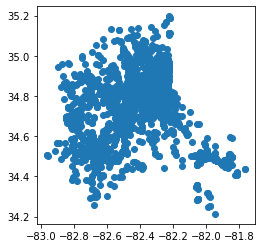

In [219]:

#cbg_infection_rates = cbg_infection_rates_np.mean(axis=1).mean(axis=0)
poi_infection_rates_df = pd.DataFrame()

poi_infection_rates_df['poi_ids'] = poi_ids

poi_infection_rates_df['poi_transmission_rate'] = np.array(fitted_model.__dict__['poi_infection_rates']).mean(axis=1).mean(axis=0)
poi_infection_rates_df['poi_new_cases']  = fitted_model.__dict__['history']['all']['num_cases_per_poi'].mean(axis=0).sum(axis=1)
# poi_infection_rates_df['new_cases_from_base'] = np.array(fitted_model.__dict__['each_cbg_new_cases_from_base']).sum(axis=0).mean(axis=0)
# cbg_infection_rates_df['poi_ids'] = cbg_ids
poi_infection_rates_df = poi_infection_rates_df.merge(core_poi_df, left_on='poi_ids', right_on=r'safegraph_place_id', how='inner')
# np.savetxt(new_name, )

poi_infection_rates_df.to_csv(POI_rates_new_name, index=False)

geometry =  gpd.points_from_xy(poi_infection_rates_df['longitude'], poi_infection_rates_df['latitude'])
shp_new_name=  POI_rates_new_name.replace(".csv", ".shp")
poi_infection_rates_gdf  = gpd.GeoDataFrame(poi_infection_rates_df, geometry=geometry).set_crs(epsg="4326")
poi_infection_rates_gdf.to_file(shp_new_name)
poi_infection_rates_gdf.plot()
poi_infection_rates_df

In [184]:
poi_infection_rates_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6550 entries, 0 to 6549
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   poi_ids                    6550 non-null   object 
 1   poi_transmission_rate      6550 non-null   float64
 2   poi_new_cases              6550 non-null   float64
 3   safegraph_place_id         6550 non-null   object 
 4   parent_safegraph_place_id  0 non-null      float64
 5   location_name              6550 non-null   object 
 6   safegraph_brand_ids        1905 non-null   object 
 7   brands                     1905 non-null   object 
 8   top_category               6550 non-null   object 
 9   sub_category               6512 non-null   object 
 10  naics_code                 6550 non-null   float64
 11  latitude                   6550 non-null   float64
 12  longitude                  6550 non-null   float64
 13  street_address             6550 non-null   objec

## Load and merge core poi

In [174]:
COLS_FROM_CORE_PLACES = ['safegraph_place_id', 'parent_safegraph_place_id', 'location_name', 'safegraph_brand_ids', 
                         'brands', 'top_category', 'sub_category', 'naics_code', 'latitude', 'longitude', 'street_address',
                         'city', 'region', 'postal_code', 'open_hours']

COLS_FROM_CORE_PLACES_FOOTPRINT = ['safegraph_place_id', 'polygon_class', 'area_square_feet', 'min_area']

COLS_FROM_WEEKLY_PATTERNS = ['safegraph_place_id', 'poi_cbg', 'visitor_home_cbgs', 'visitor_daytime_cbgs', 
                             'visitor_country_of_origin', 'distance_from_home', 'median_dwell', 'bucketed_dwell_times']


def load_core_places_footprint_data(cols_to_keep):
    FOOTPRINT_FILE = r'/media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/core_POI_area.csv' 
    area_csv = os.path.join(FOOTPRINT_FILE)
    print('Loading', area_csv)
    df = load_csv_possibly_with_dask(area_csv, usecols=cols_to_keep, use_dask=False)
    df = df.set_index('safegraph_place_id')
    print('Loaded core places footprint data for %d POIs' % len(df))
    return df

core_poi_df = helper.load_core_places_data(COLS_FROM_CORE_PLACES)
print(f"Loaded {len(core_poi_df)} core POIs.")

# Select the South Carolina 
core_poi_df = core_poi_df[core_poi_df['region'] == 'SC']
print(f"Kept {len(core_poi_df)} core POIs in South Carolina.")

footprint_df = load_core_places_footprint_data(COLS_FROM_CORE_PLACES_FOOTPRINT)
footprint_df['area_square_feet'] = footprint_df['min_area']

ids_in_footprint_but_not_core = set(footprint_df.index) - set(core_poi_df.index)
print(f"footprint_df row count: {len(footprint_df)}, core_POI row count: {len(core_poi_df)}")
print("Warning: %i/%i (%.1f%%) POIs in footprint but not core data; dropping these" % 
      (len(ids_in_footprint_but_not_core), len(footprint_df), 100. * len(ids_in_footprint_but_not_core) / len(footprint_df)))
core_poi_df = pd.merge(core_poi_df, footprint_df, how='left', left_index=True, right_index=True, validate='one_to_one')
print("Missing data for footprint columns")
print(pd.isnull(core_poi_df[footprint_df.columns]).mean())

# Remove parent POIs
parent_pois_id = core_poi_df.dropna(subset=['parent_safegraph_place_id'])['parent_safegraph_place_id'].unique()
print(f"Found {len(parent_pois_id)} parent POIs.")
parent_idx = core_poi_df['parent_safegraph_place_id'].isin(parent_pois_id)
core_poi_df = core_poi_df[~parent_idx]
core_poi_df

Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part1.csv.gz
Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part2.csv.gz
Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part3.csv.gz
Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part4.csv.gz
Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part5.csv.gz
Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part6.csv.gz
Loading core places info for 6462532 POIs
Loaded 6462532 core POIs.
Kept 98962 core POIs in South Carolina.
Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/core_POI_area.csv
Loaded core places footprint data for 5941711 POIs
footprint_df row co

,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,street_address,city,region,postal_code,open_hours,polygon_class,area_square_feet,min_area
safegraph_place_id,,,,,,,,,,,,,,,,,
sg:0123236b8d4c4e81ac12673c3e621ef0,NaN,Toby's TNT Music,NaN,NaN,"Sporting Goods, Hobby, and Musical Instrument Stores",Musical Instrument and Supplies Stores,451140.0,33.516832,-81.847263,2868 Augusta Rd,Langley,SC,29851,"{ ""Mon"": [[""9:30"", ""18:00""]], ""Tue"": [[""9:30"", ""18:00""]], ""Wed"": [[""9:30"", ""18:00""]], ""Thu"": [[""...",OWNED_POLYGON,223.894463,223.894463
sg:08a7df7912ad4b5482b4a189f0bb02e6,NaN,S C Veterinary Internal Medicine,NaN,NaN,Offices of Physicians,Offices of Physicians (except Mental Health Specialists),621111.0,34.062226,-81.133517,132 Stonemark Ln,Seven Oaks,SC,29210,NaN,NaN,NaN,NaN
sg:0ff4a57b4adb42438cd1d08f0626fbef,NaN,Southern Tire of Summerville,NaN,NaN,"Automotive Parts, Accessories, and Tire Stores",Automotive Parts and Accessories Stores,441310.0,32.985588,-80.176531,427 Old Trolley Rd,Summerville,SC,29485,"{ ""Mon"": [[""8:00"", ""17:00""]], ""Tue"": [[""8:00"", ""17:00""]], ""Wed"": [[""8:00"", ""17:00""]], ""Thu"": [[""...",OWNED_POLYGON,156.261613,156.261613
sg:1013084d2ba849988ce408184cd577ef,NaN,ALDI,SG_BRAND_41267d9fb3826d417e32077a3b0a35e5,ALDI,Grocery Stores,Supermarkets and Other Grocery (except Convenience) Stores,445110.0,35.052030,-80.991332,3665 Vandora Springs Rd,Fort Mill,SC,29708,"{ ""Mon"": [[""9:00"", ""20:00""]], ""Tue"": [[""9:00"", ""20:00""]], ""Wed"": [[""9:00"", ""20:00""]], ""Thu"": [[""...",OWNED_POLYGON,1541.991825,1541.991825
sg:1aeaadadec3d48838d252ae30dc8f9cf,NaN,Franklin Baking,NaN,NaN,Bakeries and Tortilla Manufacturing,Retail Bakeries,311811.0,33.856068,-78.660151,4308 Sea Mountain Hwy,Little River,SC,29566,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sg:e24cb2758be74f309574ee510b1690d5,NaN,Skeeter's Southern BBQ,NaN,NaN,Restaurants and Other Eating Places,Full-Service Restaurants,722511.0,32.428663,-80.774718,17 Market,Beaufort,SC,29906,"{ ""Mon"": [], ""Tue"": [[""11:00"", ""21:00""]], ""Wed"": [[""11:00"", ""21:00""]], ""Thu"": [[""11:00"", ""21:00""...",NaN,NaN,NaN
sg:e5292fd98e4e373ea9423b1129479957,NaN,Swami Food Store,NaN,NaN,Gasoline Stations,Gasoline Stations with Convenience Stores,447110.0,34.513375,-82.664592,830 Bleckley St,Anderson,SC,29625,NaN,NaN,289.754907,289.754907
sg:e5eee29d6c714f069b616024cb2922d4,NaN,Joseph Cipriano,NaN,NaN,Offices of Other Health Practitioners,Offices of Chiropractors,621310.0,34.949171,-81.935556,104 N Daniel Morgan Ave,Spartanburg,SC,29306,"{ ""Mon"": [[""11:00"", ""20:00""]], ""Tue"": [[""11:00"", ""20:00""]], ""Wed"": [[""11:00"", ""20:00""]], ""Thu"": ...",OWNED_POLYGON,312.745260,312.745260


In [176]:
core_poi_df.reset_index().to_csv(r'/media/gpu/Seagate/extra_safegraph_aggregate_models/SC_core_POI.csv', index=False)

In [120]:
poi_infection_rates_df['poi_new_cases'].sum()

12797.398111260782

In [123]:
poi_infection_rates = fitted_model.__dict__['poi_infection_rates']

poi_infection_rates = np.array(poi_infection_rates)

poi_infection_rates.shape

(984, 30, 6158)

# Tools

## Select CBG in counties

In [ ]:
#fips = ['45017', '45039', '45055', '45063', '45079', '45081']   # MSA fips: 'Columbia_SC

# fips = ['45015', '45019', '45035']  # MSA fips: 'Charleston-North Charleston; SC'


fips = ['45007', '45045', '45059', '45077']  # MSA fips: 'Greenville-Anderson-Mauldin; SC'

In [25]:
csvs = [r'J:\extra_safegraph_aggregate_models\best_202101_Charleston\cbg_rates.csv',
        r'J:\extra_safegraph_aggregate_models\best_202101_Columbia\cbg_rates.csv',
        r'J:\extra_safegraph_aggregate_models\best_202101_Greenville\cbg_rates.csv'
        ]

fips_list = [['45015', '45019', '45035'],
    ['45017', '45039', '45055', '45063', '45079', '45081'],
    ['45007', '45045', '45059', '45077'] 
]

def select_CBG_in_counties(df, county_fips_column, county_fips_list):
#     print(county_fips_list)
    df[county_fips_column] = df[county_fips_column].astype(str)
    df2 = df[df[county_fips_column].isin(county_fips_list)]
    return df2

df_list = []
county_fips_column = 'county_fips'
for idx, c in enumerate(csvs):
    df = pd.read_csv(c)
    county_fips_list = fips_list[idx]
    df2 = select_CBG_in_counties(df, county_fips_column, county_fips_list)
#     print(df2)
    df_list.append(df2)
    
df_all = pd.concat(df_list)
df_all.to_csv(r'J:\extra_safegraph_aggregate_models\SC_maps\SC_3MSA_cbg.csv',index=False)
df_all

,cbg_fips,cbg_transmission_rate,new_cases_from_poi,new_cases_from_base,new_cases,county_fips
51,450150201011,0.000028,4.800000,25.000000,29.800000,45015
52,450150201012,0.000029,9.533333,50.900000,60.433333,45015
53,450150201021,0.000031,10.700000,41.766667,52.466667,45015
54,450150201022,0.000044,14.266667,58.700000,72.966667,45015
55,450150202011,0.000027,6.800000,35.733333,42.533333,45015
...,...,...,...,...,...,...
758,450770112042,0.000067,13.300000,125.900000,139.200000,45077
759,450770112043,0.000069,6.400000,66.633333,73.033333,45077
760,450770112051,0.000063,4.266667,47.466667,51.733333,45077
761,450770112052,0.000070,10.866667,83.366667,94.233333,45077


In [22]:
df_all['new_cases'].sum()

122505.03333333334

In [24]:
df_all.groupby('county_fips').sum()

,cbg_fips,cbg_transmission_rate,new_cases_from_poi,new_cases_from_base,new_cases
county_fips,,,,,
45007,56258761056088,0.007051,2493.466667,9706.800000,12200.266667
45015,44114720212716,0.003185,1459.400000,6335.366667,7794.766667
45017,5402154029031,0.000593,76.433333,627.833333,704.266667
45019,103993897505399,0.007903,2934.300000,11931.633333,14865.933333
45035,30173457114994,0.003161,1125.633333,6524.633333,7650.266667
45039,8107192860044,0.000702,153.400000,753.700000,907.100000
45045,114864756642424,0.016587,3021.733333,27912.133333,30933.866667
45055,19374067352621,0.002069,359.233333,2675.033333,3034.266667
45059,26134753877841,0.002829,402.800000,2902.233333,3305.033333


## Merge the results to CBG shape file

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as tick
from collections import Counter 
import datetime
import os
import pickle

import geopandas as gpd

In [40]:
cbg_shp_file = r'J:\extra_safegraph_aggregate_models\SC_maps\SC_blockgroups_MSA.shp'
cbg_gdf = gpd.read_file(cbg_shp_file)
# cbg_gdf
cbg_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3059 entries, 0 to 3058
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    3059 non-null   float64 
 1   STATEFP     3059 non-null   object  
 2   COUNTYFP    3059 non-null   object  
 3   TRACTCE     3059 non-null   object  
 4   BLKGRPCE    3059 non-null   object  
 5   GEOID       3059 non-null   object  
 6   NAMELSAD    3059 non-null   object  
 7   MTFCC       3059 non-null   object  
 8   FUNCSTAT    3059 non-null   object  
 9   ALAND       3059 non-null   float64 
 10  AWATER      3059 non-null   float64 
 11  INTPTLAT    3059 non-null   object  
 12  INTPTLON    3059 non-null   object  
 13  Shape_Leng  3059 non-null   float64 
 14  Shape_Area  3059 non-null   float64 
 15  GEOID_Data  3059 non-null   object  
 16  CNT_FIPS    3059 non-null   object  
 17  OID_        3059 non-null   int64   
 18  CBSA_Code   3059 non-null   int64   
 19

In [41]:
cbg_rate_csv = r'J:\extra_safegraph_aggregate_models\SC_maps\SC_3MSA_cbg.csv'
cbg_rates_df = pd.read_csv(cbg_rate_csv)
cbg_rates_df['cbg_fips'] = cbg_rates_df['cbg_fips'].astype(str)
# cbg_rates_df
cbg_rates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   cbg_fips               1385 non-null   object 
 1   cbg_transmission_rate  1385 non-null   float64
 2   new_cases_from_poi     1385 non-null   float64
 3   new_cases_from_base    1385 non-null   float64
 4   new_cases              1385 non-null   float64
 5   county_fips            1385 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 65.0+ KB


In [43]:
merged_gdf = cbg_gdf.merge(cbg_rates_df, left_on='GEOID', right_on='cbg_fips', how='left')
merged_gdf.to_file(r'J:\extra_safegraph_aggregate_models\SC_maps\SC_blockgroups_MSA_rates.shp')

<ipython-input-43-d6f58ab4dffc>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_gdf.to_file(r'J:\extra_safegraph_aggregate_models\SC_maps\SC_blockgroups_MSA_rates.shp')


In [35]:
cbg_rates_df.groupby('county_fips').sum()

,cbg_fips,cbg_transmission_rate,new_cases_from_poi,new_cases_from_base,new_cases
county_fips,,,,,
45007,56258761056088,0.007051,2493.466667,9706.800000,12200.266667
45015,44114720212716,0.003185,1459.400000,6335.366667,7794.766667
45017,5402154029031,0.000593,76.433333,627.833333,704.266667
45019,103993897505399,0.007903,2934.300000,11931.633333,14865.933333
45035,30173457114994,0.003161,1125.633333,6524.633333,7650.266667
45039,8107192860044,0.000702,153.400000,753.700000,907.100000
45045,114864756642424,0.016587,3021.733333,27912.133333,30933.866667
45055,19374067352621,0.002069,359.233333,2675.033333,3034.266667
45059,26134753877841,0.002829,402.800000,2902.233333,3305.033333


## Analyze results

In [50]:
acs_csv = r'H:\covid_mobility_results\new_census_data\ACS_2019_5YR_BG\ACS_race_cbsa_income_2019.zip'
acs_df = pd.read_csv(acs_csv)
acs_df['cbg_fips'] = acs_df['GEOID_Data'].str[-12:]
acs_df.head(1)

,OBJECTID,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,INTPTLAT,INTPTLON,Shape_Area,GEOID_Data,county_code,...,County/County Equivalent,State Name,FIPS State Code,FIPS County Code,GEOID,total_household_income,total_households,mean_household_income,median_household_income,cbg_fips
0,1.0,1,73,5903,3,33.603461,-86.680672,2.029247e+06,15000US010730059033,1073,...,Jefferson County,Alabama,1,73,15000US010730059033,38984602.0,811.0,48069.792848,41875,010730059033


In [48]:
cbg_rate_csv = r'J:\extra_safegraph_aggregate_models\SC_maps\SC_3MSA_cbg.csv'
cbg_rates_df = pd.read_csv(cbg_rate_csv)
cbg_rates_df['cbg_fips'] = cbg_rates_df['cbg_fips'].astype(str)

In [53]:
acs_rates_df = cbg_rates_df.merge(acs_df[['cbg_total_population', 'cbg_fips']], left_on='cbg_fips', right_on='cbg_fips')
acs_rates_df

,cbg_fips,cbg_transmission_rate,new_cases_from_poi,new_cases_from_base,new_cases,county_fips,cbg_total_population
0,450150201011,0.000028,4.800000,25.000000,29.800000,45015,1023
1,450150201012,0.000029,9.533333,50.900000,60.433333,45015,1931
2,450150201021,0.000031,10.700000,41.766667,52.466667,45015,1511
3,450150201022,0.000044,14.266667,58.700000,72.966667,45015,1475
4,450150202011,0.000027,6.800000,35.733333,42.533333,45015,1501
...,...,...,...,...,...,...,...
1380,450770112042,0.000067,13.300000,125.900000,139.200000,45077,2277
1381,450770112043,0.000069,6.400000,66.633333,73.033333,45077,1209
1382,450770112051,0.000063,4.266667,47.466667,51.733333,45077,903
1383,450770112052,0.000070,10.866667,83.366667,94.233333,45077,1468


R squared: 0.8557546248482082
reg.coef_: [[0.0477591]]


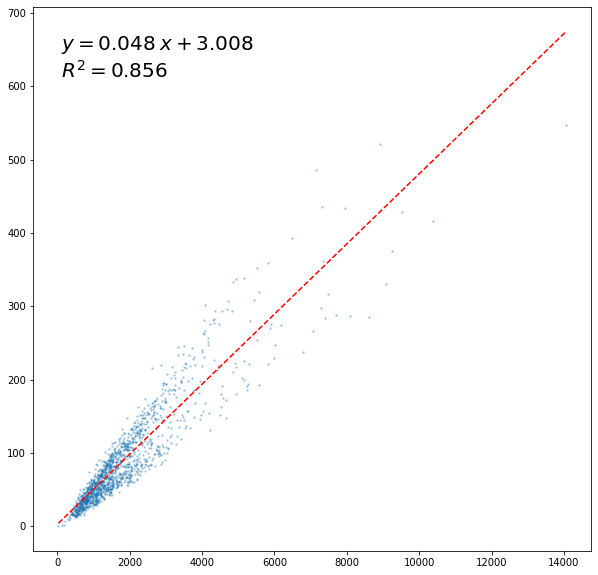

In [64]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import r2_score

def draw_r2_squared(ax2, x_true, y_observed):
    x_true = np.array(x_true).reshape((-1, 1))
    y_observed = np.array(y_observed).reshape((-1, 1))
    reg = LR().fit(x_true, y_observed)
    z = np.polyfit(x_true.ravel(), y_observed.ravel(), 1)
    p = np.poly1d(z)
    y_pred = p(x_true)
    R_squared = r2_score(y_observed, y_pred)
    # print()
    print("R squared:", R_squared)
    print("reg.coef_:", reg.coef_)
    text = f"$y={z[0]:0.3f}\:x{z[1]:+0.3f}$\n$R^2 = {R_squared:0.3f}$"
    ax2.scatter(x=x_true, y=y_observed, s=2, alpha=0.3)
    ax2.text(0.05, 0.95, text, 
               transform=plt.gca().transAxes,
               fontsize=20,
               verticalalignment='top')
    
    # draw trend line
    line_ends = [min(x_true), max(x_true)]
    end_preds = p(line_ends)
    ax2.plot(line_ends, end_preds, 'r--')
    
import matplotlib.pyplot as plt    
fig, ax = plt.subplots(figsize=(10, 10)) 
draw_r2_squared(ax, x_true=acs_rates_df['cbg_total_population'], y_observed=acs_rates_df['new_cases'])  

R squared: 0.7088812250277539
reg.coef_: [[0.00675327]]


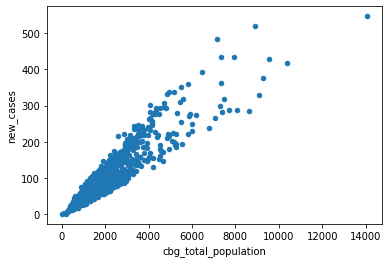

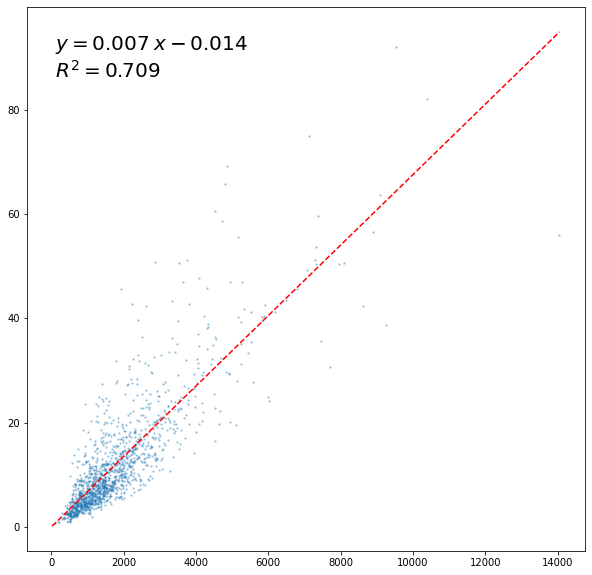

In [65]:
acs_rates_df.plot.scatter(x='cbg_total_population', y='new_cases')

import matplotlib.pyplot as plt    
fig, ax = plt.subplots(figsize=(10, 10)) 
draw_r2_squared(ax, x_true=acs_rates_df['cbg_total_population'], y_observed=acs_rates_df['new_cases_from_poi'])  

R squared: 0.8351372068184174
reg.coef_: [[0.04100583]]


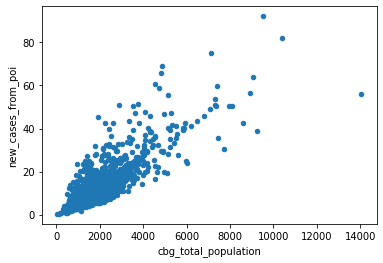

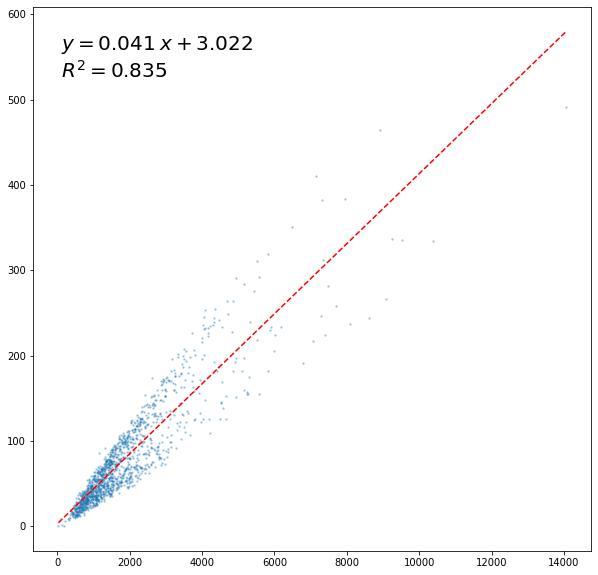

In [66]:
acs_rates_df.plot.scatter(x='cbg_total_population', y='new_cases_from_poi')

import matplotlib.pyplot as plt    
fig, ax = plt.subplots(figsize=(10, 10)) 
draw_r2_squared(ax, x_true=acs_rates_df['cbg_total_population'], y_observed=acs_rates_df['new_cases_from_base'])  

In [ ]:
acs_rates_df.plot.scatter(x='cbg_total_population', y='new_cases_from_base')

(<AxesSubplot:ylabel='Frequency'>, 1454.0)

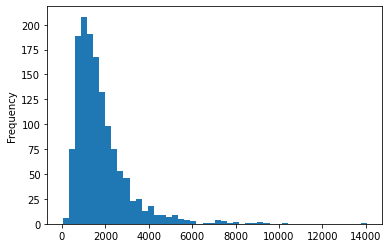

In [77]:
acs_rates_df['cbg_total_population'].plot.hist(bins=50), acs_rates_df['cbg_total_population'].median()

In [73]:
acs_rates_df

,cbg_fips,cbg_transmission_rate,new_cases_from_poi,new_cases_from_base,new_cases,county_fips,cbg_total_population
0,450150201011,0.000028,4.800000,25.000000,29.800000,45015,1023
1,450150201012,0.000029,9.533333,50.900000,60.433333,45015,1931
2,450150201021,0.000031,10.700000,41.766667,52.466667,45015,1511
3,450150201022,0.000044,14.266667,58.700000,72.966667,45015,1475
4,450150202011,0.000027,6.800000,35.733333,42.533333,45015,1501
...,...,...,...,...,...,...,...
1380,450770112042,0.000067,13.300000,125.900000,139.200000,45077,2277
1381,450770112043,0.000069,6.400000,66.633333,73.033333,45077,1209
1382,450770112051,0.000063,4.266667,47.466667,51.733333,45077,903
1383,450770112052,0.000070,10.866667,83.366667,94.233333,45077,1468


In [4]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


# Not used below

In [380]:
#dir(fitted_model)

In [11]:

import json
import pickle

# pkl = r'/media/gpu/easystore/extra_safegraph_aggregate_models/full_models/fitted_model_2021_10_06_15_38_48_687729.pkl'
pkl = r'/media/gpu/Seagate/extra_safegraph_aggregate_models/full_models/fitted_model_Huan_selected_normal_grid_search.pkl'
# pkl = r'J:\extra_safegraph_aggregate_models\full_models\fitted_model_Huan_selected_normal_grid_search.pkl'

fitted_model = pickle.load(open(pkl, 'rb'))

model_results_to_save_separately = {}
for attr_to_save_separately in [ 'cbg_new_cases_from_poi']:  # 'history',
    model_results_to_save_separately[attr_to_save_separately] = getattr(fitted_model, attr_to_save_separately)
    print(getattr(fitted_model, attr_to_save_separately))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [33]:
new_cases_from_poi = fitted_model.__dict__['history']['all']['num_cases_per_poi'].mean(axis=0)
new_cases_from_poi.sum()

12332.21713901094

In [35]:
fitted_model.__dict__['history']['all']['num_cases_per_poi'].shape

(30, 7871, 41)

In [24]:
fitted_model.__dict__['history']['all'].keys()

dict_keys(['total_pop', 'num_cbgs', 'new_cases', 'new_cases_from_poi', 'new_cases_from_base', 'new_confirmed_cases', 'new_deaths', 'susceptible', 'latent', 'infected', 'removed', 'num_out', 'num_cbgs_with_no_out', 'ipf_iter_col_num_out', 'ipf_iter_row_num_out', 'before_ipf_num_out', 'num_cases_per_poi'])

In [62]:
new_cases_from_poi = fitted_model.__dict__['history']['all']['new_cases_from_poi'].mean(axis=0) 
#np.savetxt(r'/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101/cbg_new_cases_from_poi.txt', new_cases_from_poi)
new_cases_from_poi.shape

(984,)

In [5]:
cbg_new_cases_from_base = fitted_model.__dict__['history']['all']['new_cases_from_base'].mean(axis=0) 
# np.savetxt(r'/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101/cbg_new_cases_from_base.txt', cbg_new_cases_from_base)
cbg_new_cases_from_base.shape


(984,)

In [13]:
cbg_new_cases_from_base = fitted_model.__dict__['history']['all']['new_cases_from_base'].mean(axis=0) 

cbg_new_cases_from_base.sum()

78348.7

In [35]:
import numpy as np
each_cbg_new_cases_from_poi = fitted_model.__dict__['each_cbg_new_cases_from_poi']
each_cbg_new_cases_from_poi = np.array(each_cbg_new_cases_from_poi)
each_cbg_new_cases_from_poi = each_cbg_new_cases_from_poi.sum(axis=0).mean(axis=0)
np.savetxt(r'/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101/each_cbg_new_cases_from_poi.txt', each_cbg_new_cases_from_poi)

each_cbg_new_cases_from_poi.shape

(904,)

In [29]:
import numpy as np
each_cbg_new_cases_from_base = fitted_model.__dict__['each_cbg_new_cases_from_base']
each_cbg_new_cases_from_base = np.array(each_cbg_new_cases_from_base)
each_cbg_new_cases_from_base = each_cbg_new_cases_from_base.sum(axis=0).mean(axis=0)
np.savetxt(r'/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101/each_cbg_new_cases_from_base.txt', each_cbg_new_cases_from_base)

each_cbg_new_cases_from_base.shape

(904,)

In [36]:
each_cbg_new_cases_from_base.sum()

78348.70000000001

In [37]:
each_cbg_new_cases_from_poi.sum()

10102.533333333333

## link the blockgroup_id

In [3]:
import pandas as pd
cbg_id_csv = r'H:\all_aggregate_data\ipf_output\Columbia_SC\2020-11-30_to_2021-04-05_cbg_ids.csv'
cbg_id_df = pd.read_csv(cbg_id_csv)
cbg_id_df

,cbg_id
0,130510107001
1,130730301023
2,130730303042
3,130730303061
4,130730303082
...,...
899,450910615013
900,450910615023
901,450910617061
902,450910617071


In [11]:
# read the new_cases from base and POI
each_cbg_from_base_csv = r'J:\extra_safegraph_aggregate_models\best_202101\each_cbg_new_cases_from_base.txt'
each_cbg_from_base_df = pd.read_csv(each_cbg_from_base_csv, header=None)
each_cbg_from_base_df.columns = ['base_case']

each_cbg_from_poi_csv = r'J:\extra_safegraph_aggregate_models\best_202101\each_cbg_new_cases_from_poi.txt'
each_cbg_from_poi_df = pd.read_csv(each_cbg_from_poi_csv, header=None)
each_cbg_from_poi_df.columns = ['poi_case']

each_cbg_from_base_df, each_cbg_from_poi_df

(      base_case
 0    671.333333
 1    221.633333
 2    409.600000
 3    248.500000
 4    428.133333
 ..          ...
 899  131.700000
 900  160.400000
 901  186.500000
 902  287.033333
 903  252.966667
 
 [904 rows x 1 columns],
       poi_case
 0    53.633333
 1    30.900000
 2    33.500000
 3    31.100000
 4    46.333333
 ..         ...
 899  25.933333
 900  23.766667
 901  24.633333
 902  31.800000
 903  36.966667
 
 [904 rows x 1 columns])

In [15]:
merge_cbg_new_case_df = pd.concat([cbg_id_df, each_cbg_from_base_df, each_cbg_from_poi_df], axis=1)
merge_cbg_new_case_df.to_csv(r'J:\extra_safegraph_aggregate_models\best_202101\merge_cbg_new_case', index=False)

In [27]:
fitted_model.__dict__['history']['all']['num_cases_per_poi'].mean(axis=0).sum(axis=1).sum()

12332.217139010938

In [28]:
fitted_model.__dict__['history']['all']['num_cases_per_poi'].mean(axis=0).sum(axis=1).max()

2721.136862456735

In [16]:
num_cases_per_poi = fitted_model.__dict__['history']['all']['num_cases_per_poi'].mean(axis=0).sum(axis=1)

In [20]:
import numpy as np
np.savetxt(r'/media/gpu/Seagate/extra_safegraph_aggregate_models/best_202101/num_cases_per_poi.txt', num_cases_per_poi)

NameError: name 'np' is not defined

# Show a config

In [124]:
import pickle
# pkl = r'/media/gpu/easystore/extra_safegraph_aggregate_models/full_models/fitted_model_2021_10_06_15_38_48_687729.pkl'
# pkl = r'/media/gpu/Seagate/extra_safegraph_aggregate_models/data_and_model_configs/config_Huan_selected_normal_grid_search.pkl'
pkl = r'/media/gpu/Seagate/extra_safegraph_aggregate_models/data_and_model_configs/config_2021_11_28_13_18_45_911113_normal_grid_search.pkl'

fitted_model_config = pickle.load(open(pkl, 'rb'))


In [125]:
fitted_model_config.keys()

dict_keys(['model_kwargs', 'data_kwargs', 'experiment_to_run', 'version'])

In [126]:
fitted_model_config['model_kwargs'].keys()

dict_keys(['min_datetime', 'max_datetime', 'exogenous_model_kwargs', 'model_init_kwargs', 'simulation_kwargs', 'poi_attributes_to_clip', 'include_cbg_prop_out', 'include_inter_cbg_travel', 'include_mask_use', 'counties_to_track', 'poi_cbg_visits_list', 'poi_ids', 'cbg_ids'])

In [127]:
fitted_model_config['model_kwargs']['poi_ids'].shape

(6550,)

In [128]:
fitted_model_config['model_kwargs']['cbg_ids'].shape 

(904,)